# Machine Learning - Individual Assesment - University of the West of England
<a href="https://github.com/Sp0xF8/Individual-Project">GitHub Project Link</a>

# Imports

These libararies are used for all external functionality within the project.


## These imports are shared across the whole application and not specific to either model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json 

import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score,  GridSearchCV

from sklearn.impute import KNNImputer

## SVM Imports
<p>These imports are specifically related to the SVM's functionality</p>

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

## ADA Ensambles
<p>These imports are specifically related to the Ensamble models</p>

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# Getting the Data ready for interperating

## Loading the CSV Data

<p>In this stage we are using the Pandas libary to load the CSV data file.</p>
	<div style="margin-left: 20px;">
		<p>- This helps by giving us functionality to use a wide array of methods</p>
	</div>
<p>The data is then printed to allow for easy refencing and understanding of base data</p>


In [4]:
## Load the CSV file
data = pd.read_csv('diabetes.csv')

## display data
data[:]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


## Splitting Features and Labels

While a small task, this step is crucial in allowing the model to learn the correct features. When models are trained, they look at every column of the data passed to them and attempt to find commonalities in relation to the classification options provided. In this project, simple **Binary Classification** is used. This means the decision is *between **1, True, Diabetic**, or **0, False, Non-Diabetic***. The model doesnt know how to distinguish between a entry that should be a feature, or a label. This means a manual split must be preformed, this affirms which colums are which to avoid confusion. 

In [5]:
# Creating the initial X and y lists from the data CSV file
X = data.drop("Outcome", axis=1)
y = data["Outcome"]

## Initial Data Analysis

By looking at the table below, it is possible to see a few columns which have minimum values placed at 0. *This is true for **Glucose**, **Blood Pressue**, **Skin Thickness**, **Insulin** and **BMI***. This is concerning, as zero values for these features would indicate far worse problems than diabeties: ranging from pancretic failure to having died, or having no skin. If these values remain 0, they will adversly effect the preformance of the model. **Everyone should have a value for these features**. There are two options fro handeling these missing values. They could be deleted from the training set, *given the size is already smaller than preferred*, this is not preferencial. Additionally, *patients shouldnt be cast aside from the prediction algorithm simply because they only have one feature recorded*. 

The other way to handle missing data is through **Imputing**. There are many methods for imputing data, *the one focused on for this project is K-Nearest Neighbours (**KNN**)*. This involves taking each entry and plotting the distance between them, the missing features in each entry is then populated with the corrasponding feature values in the nearest neighbour. Ideally, all data points would already be complete:  imputing data allows you to simulate as if this were the case. This should help to provide more consistant results with the models.

It must be noted, ther are also zero values inside **Pregnancies**. *It is difficult to tell if these results were **not recorded**, or if they were **recorded as Zero***. There are a many number of reasons a patient *could conevievably never have been pregnant*, they could **not want kids**, or **not be able to become pregnant** through their sexual orientation or simply being the **wrong sex ($XY$, $XX$)**. Because of this, the data should not be imputed. Imputing Pregnancy data could result in harming the accuracy of the model, having **Zero pregnancies could be a relavent factor in classification**.


In [6]:
X.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


## Setup for Impution

This simple code is just used to store specific columns of the **X Data**.

**Pregnancies** is left untouched. This is used to store the entire "Pregnancies" column until impution has finished, as discussed, this data *should not be imputed*.

**No Pregnancy** is the data strcuture used to store all remaining columns. *These will be modified thoughout the impution process*. 

In [7]:
pregnancies = X["Pregnancies"]
no_pregnancy = X.drop("Pregnancies", axis=1)


no_pregnancy.isnull().sum()

Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

### Replacing Null Objects

As seen by the above printout of the sum of **Pandas.isnull** method, **there is already no data that needs imputing**: *according to the method*. The isnull function checks for explicit occurances of the NaN byte string, this is why values will continually return as being *already complete datasets*. 

It is assumed that the database used for storing the patient records will automatically set unassigned values to 0, instead of creating them as null objects. Given this, the Zeros in question must all be replaced by Null objects: allowing the *isnull* method to find them correctly. 

In [8]:
no_pregnancy.replace(0, np.nan, inplace=True)

no_pregnancy.isnull().sum()

Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64

## Visualising Ratio of missing data

This simple function is used for displaying the amount of data missing in relation to the amount of data in each column. 

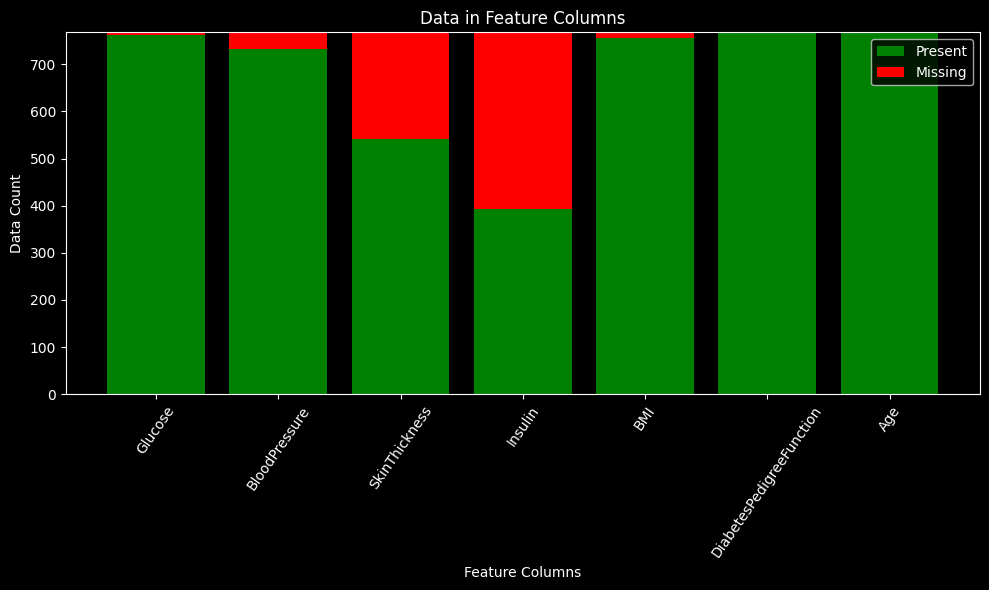

In [9]:
def visualised_missing_data(data):

	present_data = data.count()
	missing_data = len(data) - present_data

	# Plotting both present and missing data
	plt.figure(figsize=(10, 6))
	plt.bar(data.columns, present_data, color='green', label='Present')
	plt.bar(data.columns, missing_data, bottom=present_data, color='red', label='Missing')

	# Customizing plot
	plt.title('Data in Feature Columns')
	plt.xlabel('Feature Columns')
	plt.ylabel('Data Count')
	plt.xticks(rotation=55)
	plt.legend()
	plt.tight_layout()
	plt.show()


visualised_missing_data(no_pregnancy)

## Display Missing Data Frequency

This function is relativly simple and allows the operator to detect the specific locations and frequency of missing data within the structure. It takes two paramaters, the data structure for which to graph and a flag if the pregnancy column is included (the difference between 7 and 8 ticks on the x-axis). 

The heatmap colours chosen are designed to promote high contrast for people with colour-blindness, allowing whichever operator to easily understand without squinting. 

When data is detected as not being present: the existing data should have a colour of **yellow**, according to the colour bar's refernce for **1, Present**. The missing data should have a colour of **Dark Blue**.

When no data is detected as missing: the colour of existing data should be pink, as the only recorded value should be **1, Present**, this makes it the median value of the heatmap. 

In [10]:
def show_missing_data(data, flag=None):
	presence_matrix = ~data.isnull()

	# Plotting
	plt.figure(figsize=(20, 10))
	sns.heatmap(presence_matrix, cbar=True, cmap='plasma')

	if flag:	
		plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5], labels=data.columns, ha='center', va='top', rotation=45)
	else:
		plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], labels=data.columns, ha='center', va='top', rotation=45)

	plt.xlabel('Feature Columns')
	plt.ylabel('Data Entries')
	plt.title('Location of (missing) Data in Feature Columns')
	plt.show()

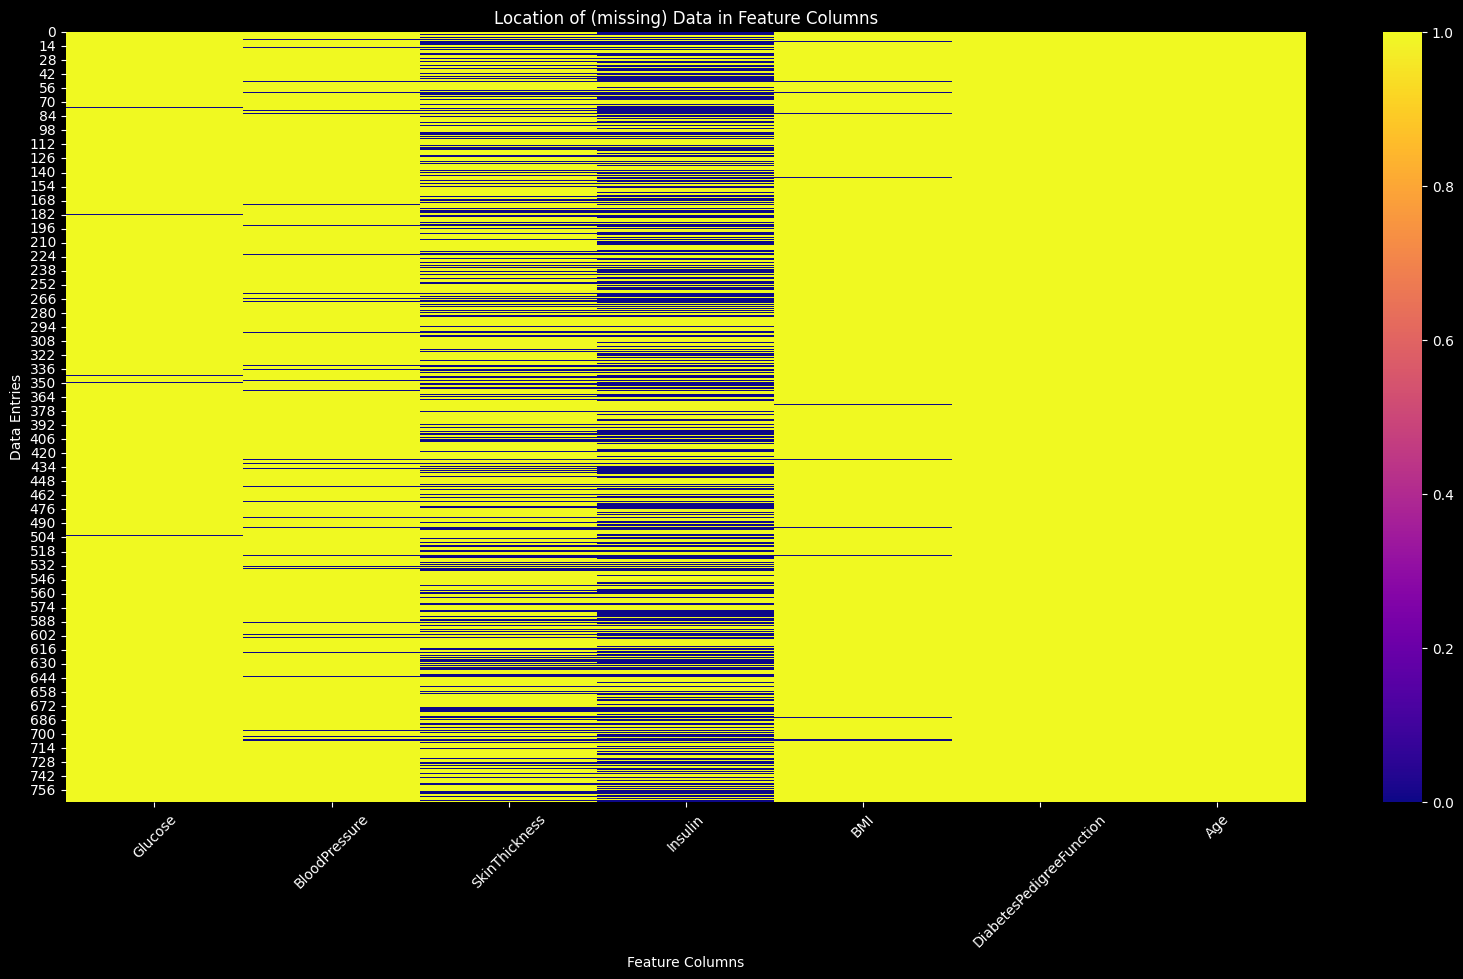

In [11]:
show_missing_data(no_pregnancy)

## Fill Missing Data Function

This simple function only acccepts one paramater, the *data structure **containing NaN objects***. This function then defines a local call to the **KNNImputer** function, provided by SKLearn. The data set is then imputed, after having trained the KNN model on the data. Finally, the imputed dataframe is returned. 

In [12]:
def fill_missing_data(data_to_impute):
	imputer = KNNImputer(n_neighbors=2)

	data_filled = imputer.fit_transform(data_to_impute)

	return pd.DataFrame(data_filled, columns=data_to_impute.columns)

## Imputing Data 

Here, the data is imputed and as saved under a new variable: **pure_data**. This is then checked once again for Null data, **an entirely pink graph shows a pure dataset**. The total number of missing features is also printed to reclarify and confusion the operator may have.

Total Missing Data:  0


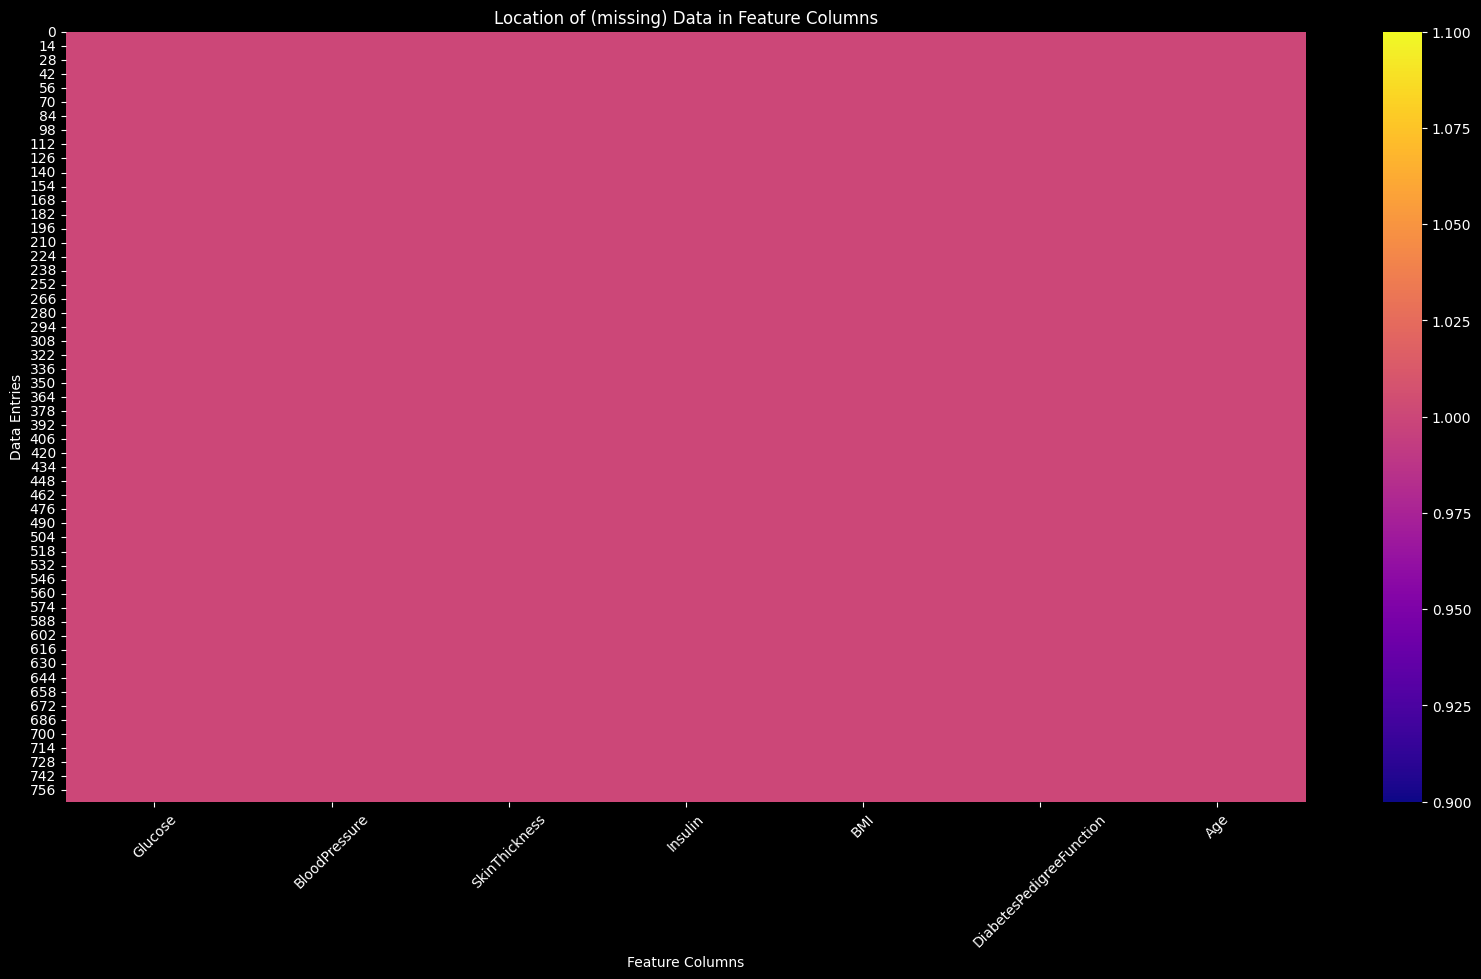

In [13]:
pure_data = fill_missing_data(no_pregnancy)


print("Total Missing Data: ", pure_data.isnull().sum().sum())
show_missing_data(pure_data)

## Reconstruct Finished data with Pregnancies

As discussed, Pregnancies are not imputed and are stored separatly during impution. Following Impution, the X dataset needs to be reconstructed with the untouched pregnancy data and the imputed features. 

In [14]:
X = pd.concat([pregnancies, pure_data], axis=1)

## Splitting Test and Training Data

In Machine Learning, it is essential to split the dataset into training and test sets.
<div style="margin-left: 20px;">
	<p>The importance of having a <strong> Validation Dataset </strong> is having a selection of data for which the learned model will be scored against. By knowing the actual label of said inputs, it is possible to match them against the predictions made by the model. This is the most accurate way to test. A counter-option would be to test against the trained data, however this wouldn't be a real-world example of predicting <em>new labels</em>. Knowing the success rate of predicted models means the model can be adjusted until the preformance is satisfactory.
	</p>
</div>


Data is split into **80% Training Data**, and **20% Testing Data**. Both sets are comprised of a list of features and a list of labels. By splitting the data into 5ths, and using 4 of them for training: we are still providing a large enough dataset for training. This is important to keep track of. *Without having a large enough training set, **the model risks skipping some important distinctions** between the classes within the classification rules*. Equally, if the testing set is not large enough, it is difficult to make strong predictions about how the model has preformed. This is because, while successfuly predicting 2/3 and 66/99 classes correctly is the same radio: one has signifigantly more opertunity to fail its predictions. *Increasing this size, **while it doesnt improve the model**, gives a much better understanding as to how the model is preforming*.

Ideally, the Training Dataset would be much larger. This would give the Machine Learning models far more information from which to make predictions and would certainly provide a more stable prediciton result. Due to the limited size of the dataset, the standard best practice of a 75:25 split was reduced. *This was done in hopes of boosting the models ability to learn from more examples*. While this does result in a smaller Test set, **benefits of raising the Test Split size outweigh the drawbacks of not being able to provide a stronger preformance metric**. 

In [15]:
#split the data into training and testing data, 80% training and 20% testing- random state is set to 42 because it is the answer to everything
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Selection

## Quick Terminology

#### Hyperplane / Decision Boundary

This can be thought of as an indefinate "line" spanning the feature space.

**The Orange line on the graphs**

#### Margin 

The margin refers to the separation between the hyperplane and the closest datapoints of each class. A larger margin hopes to corrispond to better generalisation performance on unseen data. A smaller margin aims to decreese the classification error in training, with the result being a stricter generalisation ruling.

**The margin is represented by the pink line on the graphs**

Idealistic Margin on vastly separated data:

<img src="decisionfunctions\idealistic decision boundary.png" style="height: 400px">

Realistic Margin on moderatly separated data:

<img src="decisionfunctions\more realistic decision boundary.png" style="height: 400px">

#### Underfitting

This can typically occur when a model is too simple and subsequently has not captured the underlying relationships within the data. This would result in an ultimatly smooth decision shape which creates more training errors with the hopes of creating a lower number of classification errors within generalisation.

Example of Underfit decision shape:

<img src="decisionfunctions\underfit decision function.png" style="height: 400px">

#### Overiftting

This can tpically occur when a model is too complex and has studied too many intricate details on the classes. This results in a sharp of a split between the training data, minimising the margin errors in training data. This means that unseen data, close to the known labels of diabetic patients, could result in a generalisation clasification error. This is the trade off for overfitting.


<img src="decisionfunctions\overfit decision function.png" style="height: 400px">

## Selection Process

Little information has already been said about the model, up to this point. There are lots of different models to choose between, all have their advantages and disadvantages. The goal of the model is to predict if a patient does, or does not have diabeties. Given this, it is clear the type of model must support Binary Classification: meaning the label must be either 1 or 0. The libary SKLearn provides a few excellent options for classification of this nature.  

* **Logistic Regression**
* **Support Vector Classifier (SVC)**
* **Random Forest Classifier**
* **Decision Tree Classifier**
* **Adaptive Boosting classifier (AdaBoost)**

* *Many more...*

Choosing the correct model is critical. Before this can be done, data must be analysed. Typically, data points could be plot on a graph: if only 3 features were used. From this form of visualisation, it would be evident how the data could be split. This could be an excellent use case for Linear models like Logistic Regression or SVC, with a linear kernel. Given there are 8 features to analyse: it would be difficult to conceptualise an eight-dimensional graph that could be used. One option would be a spider-graph, however this would be very messy for displaying anything more than 5 patients, it is also not appropriate for the methods of classification.

Whichever decision made will determain how the algorithm will be used to make predicitions based on the provided dataset. Given the goal is to precict weather a patient has diabeties or not, it would be a fair assumption that the program could be running on a desktop with outdated hardware. With the NHS's limited budget, the program must be non-computationally intensive, able to complete its predictions in a reasonable amount of time and to a high degree of accuracy. If the process takes too long to complete, and misses too many diabetic diagnosises, it could adversly slow down the referrals and waste hospital staff's time.

Knowing this, while SVC or Logistic Regression models can be tweaked to accept higher diemnsional data, they may not be the right choice for this project. However, given their non-intensive nature they are still worth considering as a solution for diagnosis on limited hardware. Two models were chosen to be evaluated based on metrit in this scenario: _**AdaBoost**, using RandomForest as its base estimator, and **SVC**_. Both are highly suited for Binary Classification, offering their own drawbacks and benefits. After scoring metrics have been aquried on the profiency of the models, they will be assessed based on their individual merits. 

## Support Vector Classifier (Secure Vector Machine)

The _Support Vector Classifier **(SVC)**_ is a variant of the standard _Search Vector Machine **(SVM)**_ model. SVM is a powerful supervised learning model which is primed for classification through regression. It starts by finding a hyperplane *(a line which cuts across the graph indefinetly)*, which best separates the classes. A key feature of the hyperplane is whats kown as the **margin**, *represented by $C$*. _This is thought of as a border which extends either side of the hyperplane_. 

The aim within optimisation of the margin, is to maximise the size without overfitting the model: causing it to make invalid predictions by focusing on potentially noisy or outlying data. Its important to note, while it may seem obvious that a larger value for *$C$* would result in a larger margin. __This is not the case__. *The direct oppisite is true*.

When deciding a value for $C$, its important to understand the full ramifications of a choice. The selected value will directly influence the behavior of the SVC and effect its ability to maximise the margin whilst also minimise the classification error. A *softer*, smaller, margin would lead to more classification errors, potentially improving preformance on unseen data by reducing overfitting. A *harder*, larger, margin would instead minimise training error. While this sounds like a good thing, this can lead to overfitting: resulting in the model becoming unwilling to recognise new data. 

Another key hyperparamater within the SVM is the degree of the polynomial feature, *denoted by $D$*. A simple way of thinking of $D$ is the level of complexity of the decision boundary. Higher degree polynomials can capture more specific relationships within the data. Similarly to the $C$ hyperparamater, higher degrees can easily lead to overfitting as the model will focus too heavily on the relationships within the training data and try to match them too closely. This would be great, given the SVM had already seen training data for every single combination. Since the model has limited access to training data, the decision boundary must be flexible in order to predict unseed values somewhat accurately. Its important to note that the higher the polynomial degree, the more computianally intensive the model will become. It will spend more time learning the intricate details of specific data points, and these values need to be stored in the model.

When kernels such as the *radial basis function __(RBF)__* are used, a new hyperparamater is introduced. This is __Gamma__, *denoted by a $y$*. This value is used to alter the influence of an individual training sample on the decision boundary. A lower gamma can lead to a much smoother decision boundary, whereas a higher gamma would result in a much stricter decision boundary. Smoother deicsion boundaries can lead to the training data being underfit, predicting everyone as diabetic. Stricter would see more overfitting, where the model would predict everyone as not diabetic as it would have a too finer rule about what a diabetic person is.  

The final signifigant hyperparamater is the __Coefficient__ paramater, `coef0`, denoted by an $R$. Similar to Gamma, this paramater only holds importance for kernels such as "poly" or "sigmoid" and is used to amplify or dampen the importance of a higher-degree polynomial feature in the decision boundary. Higher values for $R$ allow the model to attribute more weight to polynomial features which have captured more complex data. Conversly, a lower coeficcient recudes the regedidity of the model: helping to prevent overfitting. Careful tuning is required to find a balance between model complexity and prediction classification performance. Additionally, increasing the value for this hyperparamater can quickly cause the model to have a much greater time complexity and preformance requrements. 

### Summary

SVC is a very popular binary classification model. Known for its reliability when splitting linear data, it can also be adjusted to handle non-linear data, whilst still providing a relativly non-computationally intensive model. This is essential for the Healthcare industry, whoms funding often lacks the excess to spend on top of the line desktops in all of their wards. Given this, the model must be capable of handling multi-dimensional features: producing reliable results without becoming inefficient. This is perfectly within the scope of SVC's capability, with careful tuning of the hyperparamaters. Something to note about the SVC model, it will commonly expect data to have a mean value of 0 on a graph. This means data must be standardised so that it may be interperated as expected. SKLearn provides methods for this functionality. 

## Ada Boost with Random Forest Classifier (Ensamble)

AdaBoost is an ensamble learning technique. Ensmable techniques refer to the colaberation of multiple *weak-learners* to form an aggrogated model: capable of predicting more complex relationships that could otherwise be missed. Before the lead ensamble method, _AdaBoost_, can be described, the choice of *weak-learner* must be fully explained. The choice of estimator here: Random Forest.

### Random Forest

An extension of the standard _Decision Tree model_, **Random Forest** is an excellent candidate for binary classification.  This works by creating multiple decision trees during training, resulting in a forest of possible decisions and classification examples. Each tree generated is independently trained on a specific, randomly selected, subset of training data. This is designed to keep each tree is somewhat unique, ensuring they do not run in parralell: capturing the same relationships. If each tree were to capture the same relationships, it could negate the usefulness of having multiple trees by generating a model that has been signifigantly overfit to one section of data. Adding this randomness to sample creation gives the trees more freedom to capture more relationships and understand a more rounded view of the feature set.

After sample creation, each decision tree's root node is formed. Starting with the root node, the algorithm searches for the best split among all the possible feature. This is accomplished by first analysing each feature in the subset and determaining which will best divide the two classes, _Diabetic and Non-Diabetic_. Once the features are selected, the algortihm needs to determain the best threshold for splitting the data. This involves testing multiple values to determain which threshold might be the best for separating the data into classes. During each guess for the threshold, the classification split is tested using a preselected algorithm: using the `criterion` hyperparamater. The goal is to find a solution which maximises the reduction in impurity, which will be used as the threshold for the current split. This process is then repeated until a stopping criteria is met. Once all decision trees have grown, they should comprise of a starting node, branches, internal nodes and ending nodes, _reffered to as leafs_. Leafs are  the model is ready for classifying feature sets. When given a new datapoint, the model will survey each existing decision tree: the final result being the majority value of all predictions.

Another important hyperparamater within this model is `n_estimatiors`. This paramater is used to control the number of trees, _root nodes_, which will be created in the initialisation phase. Increasing this value typically leads to a more reliable model, as it has more trees to survey for the resulting prediction. Operators must be aware that this feature can lead to more intense computational costs, as more memory will be required to store the extra decision trees. Given the enviroment this algorithm will be preforming in, the estimators must be kept in accordance with the low-end hardware expectations of a hospital ward. 

Conversly, adjusting the `max_depth` hyperparamater can quickly invalidate the models performance. This specifies the maximum depth that each branch in the decision tree may be. Increasing this value may allow the tree to capture more information on the training data: this could adversly lead to the data becomming overfit, if raised too high. There is a *goldilocks* zone, providing a balance for discovering features and allowing elasticity in classificatio. Lowering this too far, however, could quickly lead to underfitting by not discovering enough information about the training set.

Adjusting the `max_features` hyperparamater can signicantly influence the preformance of the modle, effecting its ability to generalise unseen data. This paramater determines the maximum number of features to consider when looking for the best split at each node of the decision tree's growth. Smaller values introcude more flexibility into the prediction mode, potentially helping to reduce overfitting by frocing the model to consider a smaller subset of features. Setting this value too low, on the other hand, could limit the ability to capture signifigant patterns shared between multiple features: leading to underfitting. Setting the this paramater to a value too high could instead lead to overly complex models, promoting overfitting. 

The `min_samples_split` and `min_leaf_samples` hyperparamaters both play cricial roles in controlling thr growth and complexity of decision trees within Random Forest. The former, `min_samples_split`, sets the number of samples required to be able to preform a split. Increasing this value means the model will create less splits: reducing the computational draws of the model, and the overfitting. On the other hand, allowing for splits to occur with very small sample sizes can lead to an exponentially greater time complexity and promote models which will guess too loosely.  

Similar to `min_samples_split`, `min_leaf_samples` sets the minimum number of samples required to be considered a lead node. Larger values can lead the algorithm to prevent trees from gorwing too deep, effectivly halting the spliting process when the number of samples after a split falls below the specified threshold. This form of regularisation helps to prevent overfitting by allowing simpler tree generation with fewer leaf nodes. It would also help to decreese computational needs. Using a value that is too high can result in underfitting, not allowing the model to create enough nodes to accuratly depict the relationships of the features discovered. 


#### Summary

Random Forest is an excellent ensamble learning model. It provides a balance between preformace and computational demands. Random forest, by its ensamble nature, is robut to outliers and noisy features: making it an excellent choice for medical diagnosis, which regularly handles paitents who do not fit with the standardised norms. By making use of having multiple decision trees in the forest, the model will conduct a survey. The most popular decision is used as the predicted result. This is great, as it allows successing trees to potentially catch relationships which were not previously discovered by the initial tree. Overfitting is highly possible in this type of model, similar to underfitting, this makes careful consideration of the hyperparamaters vital. Additionally, unlike the SVM model, Random Forest does not assume any positions on a graph and instead fouses on relative values between features. Overall, this model has the ability to be highly effective when given the right paramaters, but could result in a more computinally intensive modle. 

### Adaptive Boost (AdaBoost)

As mentioned, AdaBoost provides a method for aggrogating multiple instances of _weak-learners_ to result in a stronger conclusion. In this scenario, Random Forest is used a the `estimator` paramater. Upon initialisation, the algorithm starts a loop: assigning weights to every record in the training data. Initially, these are all equal. When the first weak learner is created, it preforms a standard Random Forest calculation. After training the Random Forest, weights of misclassified training data are given higher priority. The aim of this is to focus the following models on where the previous model has made mistakes. This aims to help find a better proportion of correctly classified patients, espically those who were previously misclassified. Additionally, correctly classified training data is given a lower weight. This is to help prevent overfitting, allowing the model to stretch out and find different relationships for individual missed datapoints. 

After the model has been fully trained, it's Weighted Error Rate is calculated. This is simply the sum of the weights of the misclassified examples divided by the total sum of all weights. This value is saved and used to identify the preformance of the individual learner. A Lower weight is desirable, this means less items were misclassified. This process is repeated for each sebsequent iteration of weak-learner creation until the number of weak learners, `n_estimators`, has been met. Changing the number of estimators can be invaluable. It can be the difference between finding the sweetspot in a model's complexity and computational requiremnts. Raising this number requires a direct proportional increase in the amount of memory required for task completion, this is because AdaBoost needs to store each model until the class is destoryed. Having a value considered low could cause the model to underfit, while increasing the number of estimators could lead to overfitting. 

The `learning_rate` hyperparamater is used to control the contribution of a weak learner to the final ensamble. For example, a smaller learning rate results in more restrictive updating of the weights generated by the **weighted error calculation**. Using a slower learning rate would allow for more cautious studying of the potential relationships, reducing the risk of potential overfitting and improving the models ability to generalise unseen data. If a lower value is used, a higher number of `n_estimators` must be used: balancing the constrictive nature of how weights are handled on a lower learning rate. A higher learning rate increases the weight applied to each weak learner, causing it to have a greater effect on the final model. This can easily lead to overfitting: from testing, any learning rate over 3 will automatically cause insense overfitting.

The final signifigant paramater for this model is `random_state`. This paramater, while simple, allows the operator to acheive repeatable results by seeding the random number generator. This keeps each independent test fair, as they will all be given the same splits when paramaters match. Changing this value will lead to different results, as the starting point for nodes is determained by this seeded random number. Typically, another hyperparamater could also be analysed: `algorithm`. This can be used to change how the model behaves and what kinds of outputs will be produced. Given the developers of the SKLearn module has marked the `SAMME.R` algorithm as depricated, this was discounted from analysis. After discounting this algorithm, only one remains. The `SAMME` is an algorithm, a predecessor `SAMME.R`, which only results in Binary Classification. This is acceptable, as this is the exact form of classification required for this project. 

#### Summary

AdaBoost is a powerful ensamble learning algorithm which combines multiple weak learners to define a strong classifier. Itterativly training each weak learner, it focuses on the examples what training data was previously misclassifed by other weak learners, assigning weights to each weak learner depending on it's performance. By adaptively adjusting the weights of training data after each iteration, the Adaptive Boost model is able to focus succesing learners more heavily on the missed classifications. Through this pratice, AdaBoost can produce an ensamble model which easily captures complex patterns in data while minimising overfitting. Its flexibility and robustness allow it to handle multi-dimensional data and is an excellent Binary classifier. It must be mentioned, Adaboost can be highly sensitive to outlyers and requires high computational needs in relation to SVM: due to its iterative nature. Given the volatility of the paramaters, careful tuneing must take place to produce viable results. Overall, AdaBoost is an algorithm which promises high performance in return for careful attention. Tuning hyperparamaters may take time, and training may take longer than its SVM counterargument, but in a situation were missed diagnoses can cause further health risks and put more strain on the healthcare industry: a slightly longer wait is worth more accurate results.

### Ada Boost with Random Forest Explained

Adaboost and Random Forest are two highly popular ensamble learning methods in Machine learning, each brining their own strengths and weaknesses. Adaboost is designed to combine multiple weak classifiers into a singular strong one. Random Forest, on the other hand, builds multiple decision trees and aggragstes their outputs to make predicitons. When used together, AdaBoost can help to capture RandomForest shortcomings, inhancing the overall model performance. 

One reason Adaboost works so well with Random Forest is they are both based on different principles of ensamble learning. Adaboost foucses on sequentially improving the perofrmance of the weak learners by assinging higher weights to the misclassified instances in each iteration, whereas Random Forest builds multiple independent decision trees. Coming these two methods can lead to stronger models which levelerage the best features of each to produce a more robust and accurate model. 

Random forest tends to perofmr well on multi-diemnsional datasets which include complex relationships between featues. It can also capture non-linear realtionships, making it ideal for analyisng patient data: both being non-linear and multi-dimensional. Random Forest can suffer from overfitting, espically when dealing with noisy data or outlyers. AdaBoost can help to negate this issue by focusing its on the difficult to classify instances during training. This should help to improve generalisation by providing more varied decisions.

Diversity among the weak learners is crucial for the succes of an AdaBoost model. Random Forest naturally acheives this by traiing multiple decision treees on different subsets of data and features. When combining this randomised learning style with a progressive focus of Adaboost, the ensamble is able to reduce the bias by sequentially adjusting the weights of misclassified datapoints. The resulting model benefits from the diversity of the Random Forest classifer and the robustness of the AdaBoost algorithm.

Overall, AdaBoost compliments Random Forest by enhancing its generalisation ability, helping to reduce overfitting and improve the diversity of the decision function. By carefully tuning the hyperparamaters, it is possible to leverage the sterngths of both techniques. Final models can acheive a higher predictive accuracy on unseen data and boost robustness across a wider dataset.

## Model Suitability

After analysis, AdaBoost accompanied by Random Forest aswel as the Support Vector Classifier offer a multitude of hyperparamaters to control the flow of the model. Each has the potential to provide great perofrmance after careful tuning and are excellent examples of non-computationally intensive models capable of precise Binary Classification. Between the two, AdaBoost provides more robut predicitions at the sacrifice of reuqireiing stronger hardware. Given the healthcare sector's known low budget, this may not be ideal as desktops in hospital wards are likely out of date.

This is where the SVC model can help. Given it's, relative to a complex Ada Model, low computational requiremnts, it could be a diamond in the rough. While predictions may not be as accurate, they will complete quicker. When processing potentially hundreds of thousands of patient records, this might be preferable.

These models both have excellent viability to service the healthcare industry, however possibly at different stages. The SVC model, due to its formidable speed and abilit yot provide consistent and reliable results, may be better suited to a nation-wide patient scan to identify any potential diabeties risks. On the other hand, in one-to-one doctor-patient appointment, an Ada model might be preferencial. This would help to give a more accurate prediciton and, at worst, could be left running in the background whilst the appointment is taking place.

Moreover, its essential to condider the interpertability of these models in the healcare context. While the AdaBoost combination can provide insights into feature importance, SVC might be less interperatable due to its complex decision boundaries. In a diagnosis scenaio such as this, where understanding the reasoning behind a prediction could be useful for the Operator, interpertability is necessasary for helping to explain to the patient why they were reffered.Additionally, continuous monitoring and validation of these models should occur whenever new test data can be provided. This helps to keep the predicitions relavent and assist the healtcare professionals the way the model was intended to. 

# Setting up Search

## Creating SVM Variables
These two variables are of the type Dictonary, which is similar in format to the <strong>Json</strong> file extension. Advantages of setting the models to work in this behavoiur include ease of access and increased readability. It also gives the ability to store mulitple different datatypes in one element and easily export it to a Json file.
<div style="margin-left: 20px;">
	<p>
		<strong>svm_tests</strong> 			: This Dictonary is used to store the range of hyper-paramaters passed to the depth first grid search.
	</p>
	<p>
		<strong>current_svm_data</strong> 	: This Dictionary is used to store the current hyper-paramaters being passed to the <strong>svm_model</strong> class.
	</p>
</div>


In [16]:
# Dictionary to store the tests which will be preformed on the SVM
svm_tests = {
	'C': [7, 9, 11],
	'tollerance': np.linspace(0.0001, 0.1, 100),
	'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
	'max_iter': np.linspace(10, 10000, 100).astype(int),
	'decision_function_shape': ['ovo', 'ovr'],
	'possibility': [True, False],
}

# Dictionary to store the current test's data for the SVM
current_svm_data = {
	'kernel': None,#
	'max_iter': None,
	'decision_function_shape': None,#
	'probability': None,#
	'shrinking': None,#
	'C': None,
	'tollerance':None#
}

## Creating Ensambles Variables


Simiarly to the previous definitions, these variables are also of the type Dictionary. They are, instead, however multi-layered. 
<div style="margin-left: 20px;">
	<p>
		<strong>ada_ensambles_tests</strong> : This Dictonary is used to store the range of hyper-paramaters passed to the depth first grid search.
		<div style="margin-left: 50px;">
			<p>
				<strong>Estimator</strong> 			: This Dictonary is used to store the range of hyper-paramaters passed to the <strong>Random Forest Classifier</strong>.
			</p>
			<p>
				<strong>Params</strong> 			: This Dictionary is used to store the range of hyper-paramaters passed to the <strong>Ada Boost classifier</strong>.
			</p>
		</div>
	</p>
	<hr style="width:75%;" align="left">
	<p>
		<strong>current_ada_data</strong> 	: This Dictionary is used to store the current hyper-paramaters being passed to the <strong>ada_model</strong> class.
		<div style="margin-left: 50px;">
			<p>
				<strong>Estimator</strong> 			: This Dictonary is used to store the current hyper-paramaters being passed to the <strong>Random Forest Classifier</strong>.
			</p>
			<p>
				<strong>Params</strong> 			: This Dictionary is used to store the current hyper-paramaters being passed to the <strong>Ada Boost classifier</strong>.
			</p>
		</div>
	</p>
</div>


In [17]:
# Dictionary to store the tests which will be preformed on the AdaBoost Classifier and Random Forest Classifier
ada_ensambles_tests = {
	'Estimator': {
		'n_estimators': [50],
		'criterion': ['gini', 'entropy', 'log_loss'],
		'max_features': ['sqrt', 'log2'],
		'bootstrap': [True, False],
		'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
		'min_samples_leaf': [2, 3, 4, 5]
	},
	'Params': {
		'n_estimators': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
		'learning_rate': np.linspace(0.1, 3, 10),
		'algorithim': ['SAMME']
	}
}

# Dictionary to store the current test's data for the AdaBoost Classifier and Random Forest Classifier
current_ada_data = {
	'Estimator': {
		'n_estimators': None,
		'criterion': None,
		'max_features': None,
		'bootstrap': None,
		'min_samples_split': None,
		'min_samples_leaf': None
	},
	'Params': {
		'n_estimators': None,
		'learning_rate': None,
		'algorithim': None
	}
}

## Defining the test comparison
These two vairables are of type List and are used to store the best solutions found and their respective metrics. This is essneital in preforming a goal orientated depth first search. Without having a comparison, how can you know if you are finding a better solution?

<div style="margin-left: 20px;">
	<p>
		<strong>solution_list</strong> 		: This List stores class objects of the top 10 solutions, allowing for instant referencing once the search has been completed.
	</p>
	<p>
		<strong>accuracy_list</strong> 		: This List stores the accuracy of the class object at the same offset and is the list used for direct comparison without having to reference the solutions list; slowing down the, already hundreds of thousands, of tests. 
	</p>
</div>


In [18]:
solution_list = []
accuracy_list = []

# Class Definitions

Using a class instead of a standard function is highly effiecent. It allows for better reuseability, and storage, of data in the long term. This is fundamental concept of Object Orientated Programming. By using OOP in this project, it is much easier to rapidly cycle through a grid of hyper paramaters and subsequently output and results gained. This also means that less indents are reuqired to accomplish the same task, resulting in cleaner code which is much easier to understand.

By choosing to use a class, there is inherent access to standardised methods: like the constructor. Both the **svm_model** and **ada_model** both use **constructurs** which accept only one paramater. These are the previously defined respective Dictionarys (**current_svm_data**, **current_ada_data**). In this regard, the constructor is used to not only setup the Machine Learning model but also used to save paramaters. These can later be referenced by a different function, printing the best solutions found by the search. 

Additionally, the **predict** method is shared between the classes. While they both have vastly different features, they return the same metric values. The models themselves are stored in function-local variables, meaning once the predictions have been made: they are destroyed, freeing memory. The metric data is then stored in appropriatly named class-vairables for later use.

### Ratios Function
This function is an easy way of returning multiple metrics in a more efficent way: using far less function calls.

#### Paramaters:

<div style="margin-left: 20px;">
	<p>
		<strong>y_true</strong> 		: This variable is of type numpy array and holds the actual true values for the test data (<strong>y_test</strong>)
	</p>
	<p>
		<strong>y_pred</strong> 		: This variable is also of type numpy array and holds the predicted values for the test data (<strong>y_test</strong>)
	</p>
</div>

#### Prediction Types:

<div style="margin-left: 20px;">
	<p>
		<strong>True Positive</strong> 		: This type of classification occurs when the model <em><strong>predicts a Positive result</strong>, and the result is <strong>actually Positive</strong></em>.
	</p>
	<p>
		<strong>True Negative</strong> 		: This type of classification occurs when the model <em><strong>predicts a Negative result</strong>, and the result is <strong>actually Negative</strong></em>.
	</p>
	<p>
		<strong>False Positive</strong> 	: This type of classification occurs when the model <em><strong>predicts a Positive result</strong>, and the result is <strong>actually Negative</strong></em>.
	</p>
	<p>
		<strong>False Negative</strong> 	: This type of classification occurs when the model <em><strong>predicts a Negative result</strong>, and the result is <strong>actually Positive</strong></em>.
	</p>
</div>



In [19]:
# Funct to test the SVM model without calling different functions, this is to make the code more readable and efficient
def ratios(y_true, y_pred):
    ## Get the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    
    ## Calculate False Negative Ratio
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    
	## Calculate Recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
	## Calculate Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
	## Calculate specificity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    return fnr, recall, precision, specificity

### Metric Variables:

<div style="margin-left: 20px;">
	<p>
		<strong>closed_pred</strong> 		: This is a variable of type Numpy Array and holds the <em>predicted true values for the test data</em> (<strong>y_pred</strong>)
	</p>
	<p>
		<strong>closed_accuracy</strong> 	: This variable is of the type Float and holds the most simple of the metrics. This is simply the number of <em>correctly classafied datapoints to the number of incorrectly classafied datapoints</em>. Having a good overall accuracy is important but, dependant on what application the model is used for, can be misappropriated.
	</p>
	<p>
		<strong>closed_precision</strong> 	: This variable is also of type Float and holds a ratio of <em>correctly identified <strong>True Positives</strong> to the total number of positive predictions</em> made by the model. This is useful for analysing the validity of the positivly predicited models. 
	</p>
	<p>
		<strong>closed_specificity</strong> : Similar to <strong>closed_precision</strong>, this variable is also Float. Instead, however, it stores the ratio of <em>correctly identified <strong>True Negatives</strong> to the total number of negative predictions</em> made by the model.  
	</p>
	<p>
		<strong>closed_recall</strong> 		: This variable type of Float is used for the <em><strong>Recall</strong>, or <strong>Sensitivity</strong>,</em> of the models predictions. This is <em>the number of <strong>True Positive</strong> predictions to the total number of positive instances</em>. Recall makes excellent pairing if <strong>closed_precision</strong> is also a metric of choice. It helps to give more complete info, as precision wil not specify how many instances were missed: only how accurate it is at finding positive predicitions. This could be misleading, as an easy way to always predict people with diabeties, without missing anyone, is to simply say <em>everyone has diabeties</em>. This would <strong><em>never miss a diabetic</strong>, but would <strong>instantly slow down formal diagnosis</strong> because everyone would be referred</em>.
	</p>
	<p>
		<strong>closed_fnr</strong> 		: This variable is of type float and holds the <em><strong>False Negative Ratio</strong></em>. This the invserse of <strong>Recall</strong>, however, for transparancy, using this as a clear metric seemed preferable. Often refered to as the <em>miss rate</em>, this metric is highly valued when missed positive instances is critical. When dealing with any form of diagnosis, it is far more important that the model can correctly identify as many <strong>True Positives</strong> as possible. <em>While it is <strong>less than ideal if a non-diabetic is referred</strong>, this would cause the diagnosis system to slow down, it is <strong>far more important that the diabetic is not overlooked</strong> and left without treatment</em>. It is important to note that <strong>this should not be the only metric used for judgement</strong>. A good choice of pairing for this metric would also be <em>Precision or Specificity</em>. Specificity would provide a well rounded overview by providing insight into if the model is simply predicting everyone as diabetic. 
	</p>
	<p>
		<strong>closed_f1</strong> 			: Of type Float, this variable stores the <em>harmonic mean of <strong>precision and recall</strong></em>. This ensures <strong>False Positives</strong> and <strong>False Negatives</strong> are accounted for, and is <em>particularly useful when neither have signifigantly different levels of importance</em>. Given the models previously stressed importance of not allowing for False Negatives, but having some leverage on False Positives: F1 scoring metrics are not entirely relavent. 
	</p>
</div>

### svm_model.predict Method

Typically, a prediction function would allow for some way of dynamically setting the data to be predicted. However, given the time complexity of the grid searches employed, it was far more efficent to define the test data globally and reference when needed. If this was to be progressed further, the predict function would need to take a multi-dimensional array as the input (representing the data to classify). For the current scenario, it is suited perfectly and offers an optimised solution.

Inside the prediction function, it begins by defining a pipline; through which, the data should be processed before reaching the **Support Vector Classifier**. Given the type of model, and the large separation of the data (*e.g pregnancies: 1, glocouse: 168), the data must be pre-processed before it can be accuratly analysed by the **SVC**. Problems can easily arise in the effectiveness of Linear based algorithms, this is where the **StandardScaler** is useful inside the pipline. Instead of predefining the the patient data (**X_train**, **X_test**, ...) after having been scaled, causing disruptions to the other ML model (**ada_model**), the data is scaled on access of the model. This means new test data added will also not need to be scaled, as the pipline will automatically handle any scaling needs. 

	closed_clf.fit(X_train, y_train)

This line of code is where the SVC Pipline is called to train the model. The first paramater, **X_train**, is then passed through the pipline. First being scaled, reducing the variance in the source data, then being passed further down the pipline to the SVC model and specified kernel. At its root, the **Standard Scaler** function is designed to help convert values from different formats into a single scale. It is designed to ensure that each feature has a mean of 0 and a unit of standard deviation. This is useful for Kernels such as *RBF*, which assumes that all features are centered around a 0 origin.

In [20]:

# SVM Model Definition
class svm_model:

	## Constructor - Takes in a data dictionary (current_svm_test) and assigns the values to the class variables
	def __init__(self, data):
		self.kernel 					= data['kernel']
		self.max_iter 					= data['max_iter']
		self.func_shape 				= data['decision_function_shape']
		self.probability 				= data['probability']
		self.shrinking 					= data['shrinking']
		self.tollerance 				= data['tollerance']
		self.C 							= data['C']



	## Predict Function - Uses the current_svm_test from the constructor to create a pipeline and predict the outcome of the test data 
	def predict(self):

		### Create the pipeline as a local variable
		closed_clf = make_pipeline(	
									StandardScaler(), # Standardise the data before training
									SVC( # Create the SVC model with the given parameters from the current_svm_test dictionary
										
										kernel=self.kernel, 
										max_iter=self.max_iter, 
										decision_function_shape=self.func_shape, 
										probability=self.probability, 
										shrinking=self.shrinking,
										C=self.C,
										tol=self.tollerance
									)
								)
		
		### Fit the model to the training data 
		closed_clf.fit(X_train, y_train)

		### Predict the outcome of the test data
		self.closed_pred 		= closed_clf.predict(X_test)

		### Calculate the accuracy, f1 score, false negative rate, recall, precision, and specificity of the model
		self.closed_accuracy 	= accuracy_score(y_test, self.closed_pred)
		self.closed_f1 			= f1_score(y_test, self.closed_pred)
		
		self.closed_fnr, self.closed_recall, self.closed_precision, self.closed_specificity	= ratios(y_test, self.closed_pred)

## ada_model.predict Method

### Random Forest Classifier
	closed_hype_clf = RandomForestClassifier(...)

1. At its basics, **Random Forest Classifier** is a combination of multiple decision trees, all trained from a different *randonly selected* datapoint. This simply involves choosing multiple random samples from the origonal dataset. These samples are then used to build trees from. 

2. At *each node of each decision tree*, a random number of features is selected (*so long as the value doesnt exceed **max_features***). This helps to ensure decision trees do not run in parralel, defeating the purpose of multiple trees. 

3. After a node has selected its features, within these selected features: the one which provides the best split, *according to the **criterion***, is chosen. 

4. The remaining data is then split into subsets based on the selected feature, creating different branches on the tree. This process is then repeated at each node until a stopping crietia is met.

5. After growing ***n_estimator*** number of trees, the results are aggrogated to make predictions. When these predicitons are made, each tree independently makes their own prediction. The final prediction for the *new input data, **X_test**, is the **average result of all of the trees***. 

### AdaBoost Classifier
	closed_clf = AdaBoostClassifier(closed_hype_clf, ...)

When you pass a Random Forest Classifier as an estimator to an AdaBoost Classifier, the AdaBoost algorithm works in conjunction with the Random Forest base estimator to create a strong ensamble model. Here's how it works:

1. The Random Forest Classifier is initialized as the base estimator within the AdaBoost. AdaBoost uses the Random Forest Classifier to build a sequence of weak learners.

2. AdaBoost trains multiple instances of the Random Forest Classifier, focusing more on the entities that were misclassified by the previous learners. This is achieved by adjusting the weights of the training entities during each iteration.

3. After training multiple Random Forest models, AdaBoost combines their predictions using a weighted voting system. The final prediction is determined from the weighted sum of individual Random Forest predictions, where the weight assigned to each model depends on its performance during training.

4. By iteratively focusing on difficult-to-classify entities and combining the predictions of multiple Random Forest models, AdaBoost enhances the overall performance of the ensamble classifier. This results in a robust and accurate model that utalises the strengths of both AdaBoost and Random Forest Classifiers.


As previously mentioned, data only needs to be scaled for models which assume the data is centered around a 0 point. Neither of these classifiers do, meaning the data can be left in its standard form. This is because they make choices based on relative values, not absolute. As mentioned, they choose splits which maximise information gain: but the splits are made independently within features, meaning no scale conflicts either.



In [21]:

# SVM Model Definition
class ada_model:

	## Constructor - Takes in a data dictionary (current_svm_test)
	def __init__(self, current_test):

		## Assign the values from the current_test dictionary to the class variables, which are also dictionaries. this removes the outer layer, improving readability later on
		self.clf_estimator = current_test['Estimator']

		self.clf_params = current_test['Params']
		

	## Predict Function - Uses the current_svm_test from the constructor to create an AdaBoost Classifier and a Random Forest Classifier to be used as an estoimator to predict the outcome of the test data
	def predict(self):

		### Create the estoimator for the AdaBoost Classifier as a local variable 
		closed_hype_clf = RandomForestClassifier(
									n_estimators=self.clf_estimator['n_estimators'], 
									criterion=self.clf_estimator['criterion'],
									max_features=self.clf_estimator['max_features'], 
									bootstrap=self.clf_estimator['bootstrap'],
									min_samples_split=self.clf_estimator['min_samples_split'], 
									min_samples_leaf=self.clf_estimator['min_samples_leaf'], 
									n_jobs=-1
								)
			
		### Create the AdaBoost Classifier as a local variable with the given parameters from the current_svm_test dictionary
		closed_clf = AdaBoostClassifier(
							closed_hype_clf,
							n_estimators=self.clf_params['n_estimators'],
							learning_rate=self.clf_params['learning_rate'],
							algorithm=self.clf_params['algorithim'],
							random_state=1)
		
		### Fit the model to the training data
		closed_clf.fit(X_train, y_train)

		### Predict the outcome of the test data
		self.closed_pred 		= closed_clf.predict(X_test)

		### Calculate the accuracy, f1 score, false negative rate, recall, precision, and specificity of the model
		self.closed_accuracy 	= accuracy_score(y_test, self.closed_pred)
		self.closed_f1 			= f1_score(y_test, self.closed_pred)
		self.closed_fnr, self.closed_recall, self.closed_precision, self.closed_specificity	= ratios(y_test, self.closed_pred)

# Helper Functions

### Convert to Serialisable
This simple helper function takes an entity as a paramater and returns it, after having been converted to a JSON serialisable type. Given the only abstract type being used is a **Numpy Int32**, there only needs to be one conditional. Every other type can be converted at base value.  

In [22]:
def convert_to_serialisable(ent):
    if isinstance(ent, np.int32):
        return int(ent)
    return ent

### Write JSON

While it would have been entirely possible to use the the classes default __dict__ function, this gives little control over the how the results are displayed: decreasing readabaility. It is true, given the JSON file extnesion, the data could simply be extracted and accessed in a more appropriate way. But it made more sense to provide a file that is also legible to a human aswel. This means that the user could quickly take a look at the results manually, without having to decypher the cryptic positioning of the variables within the dictionary.

Additionally, it would have also been possible to store the array as an array. However, given the length of the array: it seemed more logical to include it as a string, creating a row instead of a 100 line column. This also makes direct comparison between predictions and expected results much easier as they run in paralel.

#### Paramaters:
<div style="margin-left: 20px;">
	<p>
		<strong>class_name</strong> 		: This paramater should either be an <strong>svm_model</strong> or <strong>ada_model</strong>. 
	</p>
	<p>
		<strong>output_file</strong> 		: This paramater should be of type <strong>string</strong> and <em>finish with a ".json" file extension</em>. It will not create an error if a txt is used, but some json functionality could be limited.
	</p>
</div>

In [23]:
def write_json(class_name, output_file):
	
	## Create a dictionary to store the class variables and the results of the model
	class_dict = {
		"features": {# Dictionary created empty, to be filled with the features of corresponding model.
		},
		"results": { # Dictionary used to store the metrics of the model 
			"accuracy": class_name.closed_accuracy,#float
			"f1": class_name.closed_f1,#float
			"fnr": class_name.closed_fnr,#float
			"recall": class_name.closed_recall,#float
			"precision": class_name.closed_precision,#float
			"specificity": class_name.closed_specificity#float
		},
		"predictions": { # Dictionary used to store the predictions of the model
			"y_pred": str(class_name.closed_pred.tolist()),#array as string
			"y_true": str(y_test.tolist())#array as string 
		}
	}

	## Check if the class_name is an instance of the svm_model class
	if(isinstance(class_name, svm_model)):
		class_dict["features"] = { # If the class_name is an instance of the svm_model class, fill the features dictionary with the features of the model
			"kernel": str(class_name.kernel),#str
			"max_iter": class_name.max_iter,#int
			"decision_function_shape": str(class_name.func_shape),#str
			"probability": class_name.probability,#bool
			"shrinking": class_name.shrinking,#bool
			"tollerance": class_name.tollerance,#float
			"C": class_name.C#float
		}
	elif(isinstance(class_name, ada_model)):
		class_dict["features"] = { # If the class_name is an instance of the ada_model class, fill the features dictionary with the features of the model
			"Estimator": {
				"n_estimators": class_name.clf_estimator['n_estimators'],#int
				"criterion": str(class_name.clf_estimator['criterion']),#str
				"max_features": str(class_name.clf_estimator['max_features']),#str
				"bootstrap": class_name.clf_estimator['bootstrap'],#bool
				"min_samples_split": class_name.clf_estimator['min_samples_split'],#int
				"min_samples_leaf": class_name.clf_estimator['min_samples_leaf']#int
			},
			"Params": {
				"n_estimators": class_name.clf_params['n_estimators'],#int
				"learning_rate": class_name.clf_params['learning_rate'],#float
				"algorithim": str(class_name.clf_params['algorithim'])#str
			}
		}

	_tojson_ = json.dumps(class_dict, default=convert_to_serialisable, indent=4) # Convert the class_dict to a JSON string

	with open(output_file, 'a') as f: # Open the output file in append mode and write the JSON string to the file

		f.write(str(_tojson_ ) + ',\n') # Add a comma and a newline character to the end of the JSON string to separate the different tests
		

### Solution Comparison

This is quite a simple function. It checks that **closed_precision** is lower than 70%, then proceeds to compare the current test against the current Top 10 solutions found. If a new best solution is found, the **solution_list** and **accuracy_list** are appended respectivly. The solution is then written to the correctly named JSON file. If the length of the list exceeds 10 items, the item at the front of the list is removed. 

#### Paramaters:
<div style="margin-left: 20px;">
	<p>
		<strong>current_test</strong> 	: This paramater should either be an <strong>svm_model</strong> or <strong>ada_model</strong>. 
	</p>
	<p>
		<strong>solution_name</strong> 	: This paramater should be of type <strong>string</strong> and <em>finish with a ".json" file extension</em>. It will not create an error if a txt is used, but some json functionality could be limited.
	</p>
</div>

In [24]:
def check_worst(current_test, solution_name):

	if (current_test.closed_precision < 0.7):
		return

	## for each solution in the solution list, where i stores the current solution being compared to the current test
	for i in range(len(solution_list)):

		## cbeck if the current test's preformance metric is more optimal than the current solution's preformance metric
		if (current_test.closed_fnr < accuracy_list[i] or current_test.closed_fnr < 0.34):
			## append the current test to the solution list and the accuracy of the current test to the accuracy list
			solution_list.append(current_test)
			accuracy_list.append(current_test.closed_fnr)

			## write the current test to the output file
			write_json(current_test, solution_name)


			## check if the length of the solution list is greater than 10
			if(len(solution_list) > 10):
				## pop the first element from the solution list and the accuracy list
				solution_list.pop(0)
				accuracy_list.pop(0)

			return

# Systematic Grid Search

**SKLearn** deos include a standard grid search function: *GridSearchCV*. It is described as an "*exhaustive* search" over a definied paramater list. First it trains each possibility of **hyperparamaters** and scores them, using the most admirable for the final predictions. This function is ***increably exhaustive*** when searching over a large dataset. Instead of preforming an optimised search, this algorithm aims to save all possibilities in memory. This would be insignifigant when only checking a few hundred tests. However, with the hundreds of millions of combinations: **how do you know which to test**? 

It is possible to use the GridSearchCV function for these millions of test paramaters, however the computational requirements are *linear to the **number of tests** $*$ **memory usage for the model selected***. This can easily cause any computer to come to a grinding hault and freeze, even possibly resulting in a BSOD error. The *optimal memory usage should be **memory usage for the model selected** $*$ **number of best solutions***. For this search, as seen in the *Comparison Function*, the max number of best solitions to be stored in active memory should not exceed the number of best solutions, *10*, and an additional solution for the one being tested. This gives a *final memory usage of **11** $*$ **memory usage for the model selected***.

Given the memory optimisation of the custom search functions, it would be possible to preform searches on computers with limited memory availability. Dependent on the speed of the computer, and the size of the test, this could still take days to analyse for the most optimal hyperparamaters: however, in theory it should only need to run once as all best solutions found are stored in an external data-structure. **More will be spoken about that later**, but the key benefits of searching in this style is that it gives *functionalty to find the best paramaters inside of an **infinitly large pool of paramaters***. That is, ***so long as you have enough time to wait***. 

This is a deal breaker for the health industry, whos computer power usually lags behind civilisation due to lack of funding.

## Grid Search Functions

Both of these functions are structured in the same way for simplistic calling conventions, they also use the same logic: giving exceptions for differences needed by the individual model.

When the function is called, a few new *local varaibles* are defined. **iterationCount** is inconsequential to the flow of the actual search, however does it allows the program operator to see how many tests have been completed. This is used in combination with the **number_of_tests** constant, which is calculated by multiplying the length of all of the hyper paramater arrays together. These are later used to give a direct number of tests remaining, affirming to the operator: *tests are still being executed*. 

Next, the **Best Solutions** output is prepared. A new file is created in the JSON file format and a singular bracket and newline is written. This allows the different, best solutions, to be indexed and referenced as independent dictionarys. The final stage of preperation occurs when pushing an empty solution and the worst possible score for the model to acheive. This kick-starts the solution comparison, without it there is nothing to compare against and nothing to iterate. Because this data is added to the respective lists directly, there they will not be outputted to the **Best Solutions**. Neither will they be output to the **Best 10 Solutions**, the first few tests will overwite them no *matter how good they actually are*: the initial push is relativly much worse.

Finally, the bullk of the functions. Both are rooted on the principle: multiple nested for loops, incrementally cycling through the test paramaters held by **data**. These values are passed to the relative model's dictionary which is then subsequently passed to the class instance reprenting the Machine Learning model chosen. The prediction function is then called, on termination the class is passed to the *Comparison Function*. 

On completion of each itteration, an addition macro is applied to the **iterationCount** variable so that the completion percentage of the search can be accuratly seen. Every time the algorithm completes one inner loop: the **Iterations** TXT is overwritten.

Once the entire search as been completed, a final closing bracket is added to the **Best Solutions**. Finally, the **Best 10 Solutions** are produced.

### Paramaters:
<div style="margin-left: 20px;">
	<p>
		<strong>data</strong> 	: This paramater should be of type Dictionary and should hold the <strong>svm_tests</strong>, or <strong>ada_ensambles_tests</strong>. 
	</p>
</div>

### Outputs:
<div style="margin-left: 20px;">
	<p>
		<strong>Best Results</strong> 	: This output will be in the JSON file format and <em>will be generated, <strong>only  on completion of the entire search</strong></em>.
	</p>
	<p>
		<strong>Results</strong> 	: This output will be in the JSON file format and <em>will be appended <strong>every time a new best solution is found</strong></em>.
	</p>
	<p>
		<strong>Iterations</strong> 	: This output will be in the TXT file format and <em>will be overwirtten <strong>every few hundred test solutions</strong></em>.
	</p>
</div>

In [25]:
# Function to perform a depth first search on the SVM model
def svmDepthFirstSearch(data):

	## Clear the solution list and the accuracy list
	solution_list.clear()
	accuracy_list.clear()

	## Create a variable to store the number of tests that have beeb preformed
	iterationCount = 0

	## Calculate the number of tests that will be preformed
	number_of_tests = (
		len(data['kernel']) *
		len(data['decision_function_shape']) *
		len(data['possibility']) *
		len(data['possibility']) *
		len(data['max_iter']) *
		len(data['tollerance']) *
		len(data['C'])
	)


	## Setupt the svm_results.json file to store the best solutions discovered by the tests
	with open("svm_results.json", 'w') as f:
		## write the opening square bracket to the file to start the JSON array 
		f.write("[\n")
	

	## Append an empty object to the solution list and set the accuracy to the worst possible metric score
	solution_list.append(current_svm_data)
	accuracy_list.append(1.0)

	## Itterate through the different parameters in the data dictionary
	for kernel in data['kernel']:
		for function_shape in data['decision_function_shape']:
			for probability in data['possibility']:
				for shrinking in data['possibility']:
					for max_iter in data['max_iter']:
						for tol in data['tollerance']:
							for C in data['C']:

								## Set the current_svm_data dictionary to the current parameters indexed by the loop
								current_svm_data['kernel'] = kernel
								current_svm_data['decision_function_shape'] = function_shape
								current_svm_data['probability'] = probability
								current_svm_data['shrinking'] = shrinking
								current_svm_data['max_iter'] = max_iter
								current_svm_data['tollerance'] = tol
								current_svm_data['C'] = C


								## Create a new instance of the svm_model class with the current_svm_data dictionary
								current_test = svm_model(current_svm_data)

								## Call the predict method of the current_test instance
								current_test.predict()
								
								## Preform a comparison check
								check_worst(current_test, "svm_results.json")

								## Increment the iteration count
								iterationCount += 1
								
						## Write the current iteration count to the file to keep track of the progress EVERY TIME THE TOLLERANCE IS CHANGED
						with open("svm_iterations.txt", 'w') as f:
							f.write("Iteration: " + str(iterationCount) + "/" + str(number_of_tests))


	## Write the closing square bracket to the file to end the JSON array
	with open("svm_results.json", 'a') as f:
		f.write("]\n")


	## Write the best solutions to the output file
		
	with open("svm_best_results.json", 'w') as f:
		f.write("[\n")

	for i in range(len(solution_list)):
		write_json(solution_list[i], "svm_best_results.json")

	with open("svm_best_results.json", 'a') as f:
		f.write("]\n")

In [26]:
def adaDepthSearch(data):


	## Clear the solution list and the accuracy list
	solution_list.clear()
	accuracy_list.clear()

	## Create a variable to store the number of tests that have been preformed
	iterationCount = 0

	## Calculate the number of tests which will be preformed
	number_of_tests = (
		len(data['Estimator']['n_estimators']) *
		len(data['Estimator']['criterion']) *
		len(data['Estimator']['max_features']) *
		len(data['Estimator']['bootstrap']) *
		len(data['Estimator']['min_samples_split']) *
		len(data['Estimator']['min_samples_leaf']) *
		len(data['Params']['n_estimators']) *
		len(data['Params']['learning_rate']) *
		len(data['Params']['algorithim'])
	)

	## Set up the ada_results.json file to store the best solutions discovered by the tests
	with open("ada_results.json", 'w') as f:

		## write the opening square bracket to the file to start the JSON array
		f.write("[\n")
		

	## Append an empty object to the solution list
	solution_list.append(current_ada_data)
	## Set the accuracy to the worst possible metric score
	accuracy_list.append(1.0)


	## Itterate through the different parameters in the data dictionary relating to the Random Forest Classifier
	for n_estimators in data['Estimator']['n_estimators']:
		for criterion in data['Estimator']['criterion']:
			for max_features in data['Estimator']['max_features']:
				for bootstrap in data['Estimator']['bootstrap']:
					for min_samples_split in data['Estimator']['min_samples_split']:
						for min_samples_leaf in data['Estimator']['min_samples_leaf']:
							

							## Set the estimator dictionary to the current parameters indexed by the loop
							current_ada_data['Estimator']['n_estimators'] = n_estimators
							current_ada_data['Estimator']['criterion'] = criterion
							current_ada_data['Estimator']['max_features'] = max_features
							current_ada_data['Estimator']['bootstrap'] = bootstrap
							current_ada_data['Estimator']['min_samples_split'] = min_samples_split
							current_ada_data['Estimator']['min_samples_leaf'] = min_samples_leaf


							## Itterate through the different parameters in the data dictionary relating to the AdaBoost Classifier
							for n_estimators_params in data['Params']['n_estimators']:
								for learning_rate in data['Params']['learning_rate']:
									for algorithim in data['Params']['algorithim']:

										
										## Set the hyperparamaters dictionary to the current parameters indexed by the loop
										current_ada_data['Params']['n_estimators'] = n_estimators_params
										current_ada_data['Params']['learning_rate'] = learning_rate
										current_ada_data['Params']['algorithim'] = algorithim

										## Create a new instance of the ada_model class with the current_ada_data dictionary
										current_test = ada_model(current_ada_data)

										## Call the predict method of the current_test instance
										current_test.predict()
										

										## Preform a comparison check
										check_worst(current_test, "ada_results.json")

										## Increment the iteration count
										iterationCount += 1
										
									## Write the current iteration count to the file to keep track of the progress EVERY TIME THE LEARNING_RATE IS CHANGED
									with open("ada_iterations.txt", 'w') as f:
										f.write("Iteration: " + str(iterationCount) + "/" + str(number_of_tests))


	## Write the closing square bracket to the file to end the JSON array
	with open("ada_results.json", 'a') as f:
		f.write("]\n")


	## Write the best solutions to the output file
	with open("ada_best_results.json", 'w') as f:
		f.write("[\n")

	for i in range(len(solution_list)):
		write_json(solution_list[i], "ada_best_results.json")

	with open("ada_best_results.json", 'a') as f:
		f.write("]\n")

# Execute the Search Algorithms

These functions simply call the aforementioned search algorithms with the predefined list of hyperparamaters.

#### Commented out by default, this is to prevent the function from being called by **EXAMINER** when running the code: is's execution is time consuming (over 2k mins of runtime) and non-essential for the exam marking.

In [27]:
# svmDepthFirstSearch(svm_tests)

In [28]:
# adaDepthSearch(ada_ensambles_tests)

# Handling Search Results

## Read JSON Helper Function

The provided Python function, `read_json`, is designed to read a JSON file from a given file path: returning a JSON object. This will be useful for handling the results generated by the **SVM** and **ADA** searches.

In [29]:
def read_json(filepath):
	## Open the file in read mode
	with open(filepath, 'r') as f:
		## Load the JSON file into the array_of_solutions variable
		return json.load(f)

## Panda Restructure and display

Creating a panda **DataFrame** automatically converts the data into columns and rows, like a standardised table of elements. This completed data structure should be much more readable to the operator and can then be used to make predictions about how the model could preform under the correct hyperparamaters. This then displays the 80 solutions found in the previous test. It may be apparent that the **solutions320k.json** file is formatted differently to the one produced by the grid search. This results datafile was generated before the **write_json** file was designed. This previous method resulted in poor readability and messy datastrcutures. The new method is much more streamlined, but converting the reading method for the svm_results would take some consideration.

***@@**: This step is unnecessasary- it just helps to give an idea of the data to be processed, and gives a better understanding of how the proceeding functions handle said data.*

In [30]:
# Define the array to store the solutions

array_of_solutions = []

## Read the best results from the SVM model
array_of_solutions = read_json("TestOutputsSVM\soltuions320k.json")

#frame the data into a pandas dataframe
df = pd.DataFrame(array_of_solutions)

#display the data
df[:]

,kernel,func_shape,shrinking,probability,tollerance,max_iter,C,closed_accuracy,closed_precision,closed_recall,closed_f1,closed_fnr,closed_pred
0,poly,ovo,True,True,0.0002,1000,7,0.740260,0.647059,0.600000,0.622642,0.400000,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, ..."
1,poly,ovo,True,True,0.0003,1000,7,0.740260,0.647059,0.600000,0.622642,0.400000,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, ..."
2,poly,ovo,True,True,0.0004,1000,7,0.740260,0.647059,0.600000,0.622642,0.400000,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, ..."
3,poly,ovo,True,True,0.0005,1000,7,0.740260,0.647059,0.600000,0.622642,0.400000,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, ..."
4,poly,ovo,True,True,0.0006,1000,7,0.740260,0.647059,0.600000,0.622642,0.400000,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,linear,ovo,True,True,0.0006,1303,7,0.772727,0.656250,0.763636,0.705882,0.236364,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, ..."
76,linear,ovo,True,True,0.0007,1303,7,0.772727,0.656250,0.763636,0.705882,0.236364,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, ..."
77,linear,ovo,True,True,0.0008,1303,7,0.772727,0.656250,0.763636,0.705882,0.236364,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, ..."
78,linear,ovo,True,True,0.0009,1303,7,0.772727,0.656250,0.763636,0.705882,0.236364,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, ..."


## Reading Helper Functions 

These functions, while simple in nature, allow for far cleaner code: overall, improving readability. Instead of needing to write these code blocks in-line, presenting them inside functions splits the code. This in tern helps to lessen the code's indentation, negating confusion. 

### *Results to Grid* Function

These functions are designed to take the results from `read_json`, translating them into a dictionary with arrays corrisoponding to unique values for each paramater. 

They start by defining the dictionary for which to store the unique values, then itterating over each individaual entity in the results file. During itteration, each value is added to a list. Once this cycle has completed, a new dictionary is defined with the same keys. Lists are then converted into sets, removing any non-unique values, and finally converted back into lists for integrity. This final dictionary, filled with keys assosiated to unique lists is returned for later use. 

It should be worth noting that the outputs will **not** include the metrics produced by the model. These will not be needed for the proceeding functions. 

#### Paramaters:
<div style="margin-left: 20px;">
	<p>
		<strong>non_unique_values</strong> 	: This paramater is an array of dictionarys produced by the <strong>read_json()</strong> function. 
	</p>
</div>

#### Returns:
<div style="margin-left: 20px;">
	<p>
		<strong>unique_dict</strong> 	: This variable is a Dictionary which stores all unique <em>best</em> inputs assosiated with the respected model.
	</p>
</div>



In [31]:
def svm_results_to_grid(non_unique_values):

	## Create a dictionary to store the values of the non_unique_values dictionary
	search = {
		'kernel': [],
		'max_iter': [],
		'decision_function_shape': [],
		'probability': [],
		'shrinking': [],
		'C': [],
		'tollerance': [],
	}

	## Itterate through the non_unique_values dictionary
	for i in range(len(non_unique_values)):
		## Append the values to the unique_search dictionary
		search['kernel'].append(non_unique_values[i]['features']['kernel'])
		search['max_iter'].append(non_unique_values[i]['features']['max_iter'])
		search['decision_function_shape'].append(non_unique_values[i]['features']['decision_function_shape'])
		search['probability'].append(non_unique_values[i]['features']['probability'])
		search['shrinking'].append(non_unique_values[i]['features']['shrinking'])
		search['C'].append(non_unique_values[i]['features']['C'])
		search['tollerance'].append(non_unique_values[i]['features']['tollerance'])

	## Create a dictionary to store the unique values of the unique_search dictionary
	unique_dict = {
		## Cast the lists to sets to remove duplicates and then cast them back to lists
		'kernel': list(set(search['kernel'])),
		'max_iter': list(set(search['max_iter'])),
		'decision_function_shape': list(set(search['decision_function_shape'])),
		'probability': list(set(search['probability'])),
		'shrinking': list(set(search['shrinking'])),
		'C': list(set(search['C'])),
		'tol': list(set(search['tollerance'])),
	}

	## Return the unique_dict
	return unique_dict

In [32]:
def ada_results_to_grid(non_unique_values):

	## Create a dictionary to store the values of the non_unique_values dictionary
	search = {
		'estimator': {
				"n_estimators": [],#int
				"criterion": [],#str
				"max_features": [],#str
				"bootstrap": [],#bool
				"min_samples_split": [],#int
				"min_samples_leaf": []#int
			},
		'params': {
				"n_estimators": [],#int
				"learning_rate": [],#float
				"algorithim": []#str
			}
	}

	## Itterate through the non_unique_values dictionary
	for i in range(len(non_unique_values)):

		## Append the values to the unique_search dictionary
		search['estimator']['n_estimators'].append(non_unique_values[i]['features']['Estimator']['n_estimators'])
		search['estimator']['criterion'].append(non_unique_values[i]['features']['Estimator']['criterion'])
		search['estimator']['max_features'].append(non_unique_values[i]['features']['Estimator']['max_features'])
		search['estimator']['bootstrap'].append(non_unique_values[i]['features']['Estimator']['bootstrap'])
		search['estimator']['min_samples_split'].append(non_unique_values[i]['features']['Estimator']['min_samples_split'])
		search['estimator']['min_samples_leaf'].append(non_unique_values[i]['features']['Estimator']['min_samples_leaf'])

		search['params']['n_estimators'].append(non_unique_values[i]['features']['Params']['n_estimators'])
		search['params']['learning_rate'].append(non_unique_values[i]['features']['Params']['learning_rate'])
		search['params']['algorithim'].append(non_unique_values[i]['features']['Params']['algorithim'])

	## Create a dictionary to store the unique values of the unique_search dictionary
	unique_dict = {
		'estimator': {
				## Cast the lists to sets to remove duplicates and then cast them back to lists
				"n_estimators": list(set(search['estimator']['n_estimators'])),#int
				"criterion": list(set(search['estimator']['criterion'])),#str
				"max_features": list(set(search['estimator']['max_features'])),#str
				"bootstrap": list(set(search['estimator']['bootstrap'])),#bool
				"min_samples_split": list(set(search['estimator']['min_samples_split'])),#int
				"min_samples_leaf": list(set(search['estimator']['min_samples_leaf']))#int
			},
		'params': {
				"n_estimators": list(set(search['params']['n_estimators'])),#int
				"learning_rate": list(set(search['params']['learning_rate'])),#float
				"algorithm": list(set(search['params']['algorithim']))#str
			}
	}

	return unique_dict

### Small example code

This example of how functions can be used in conjunction. It is crafted so that the operator may quickly see the absolute best values for each hyper paramater. 

Stepping through this line of code: In the center we are passing the path for the *svm search results*. This function, `read_json`, then returns a array holding all of the results generated from said search. This is passed to the `svm_results_to_grid` function which, aptly named, takes an array of Dictionary objects and translated them into unique arrays of values. This ensures features are not tested more than once.The final results are then passed to the standard JSON method, `dumps`. This turns the data back into a JSON, giving a clean **print** statement without any string formatting. 

In [33]:
print("SVM Results:")
print(json.dumps(svm_results_to_grid(read_json("Assessment_Outputs/svm_results.json")), indent=8))


print("Ada Results:")
print(json.dumps(ada_results_to_grid(read_json("Assessment_Outputs/ada_results.json")), indent=8))

SVM Results:
{
        "kernel": [
                "linear"
        ],
        "max_iter": [
                3945,
                4046,
                2129,
                4853,
                6972
        ],
        "decision_function_shape": [
                "ovr",
                "ovo"
        ],
        "probability": [
                false,
                true
        ],
        "shrinking": [
                false,
                true
        ],
        "C": [
                9,
                11,
                7
        ],
        "tol": [
                0.04046363636363637,
                0.06266363636363637,
                0.07174545454545456,
                0.09394545454545455,
                0.009181818181818182,
                0.031381818181818184,
                0.0001,
                0.07578181818181819,
                0.0223,
                0.05358181818181819,
                0.08486363636363638,
                0.09798181818181818,
                

# Creating Optimised Models



## Base Class

Unlike the search classes, these were designed with inheritence. Any preprocessing of data happens in the extended class. There are three methods assosaiated with this class: The Constructor, Predict, and Print. Instead of the previous classes functionality of handling training and testing inside of the predict function, the training has been separated and moved to the constructor. 

Inside the **final_model.__init__** method, two key things happen. First the grid search is defined. This is a simple function-local variable and is not needed once the constructor has terminated: this helps to free useless memory. The **GridSearchCV** function had independent hardcoded variables and do not change inputs between the two extended classes. How they act, however, is vastly different. By leveraging the ability to pass variables to the constructor, it is possible to pass a classifier as a function paramater. This means code can be reused between extended classes without too many extra lines being added in the independent superclass. 

Next, the grid search is trained. This is where the simulations, passed to the function by the best_grid variable as a paramater, are ran. Each possible solution is scored using the defined **scoring** metric. Once the tests have concluded, the solution, which scored the best on the training data provided, will be stored in the class variable **estimator**. There, it can be easily referenced for multiple future predictions. The **best_paramaters** are also stored at this point. It gives the operator some guidance about how the current model is running, if they decide that knowing is crucial. This could occur in multiple instances, a common example would be to diagnose a problem with the Machine Learning algorithm. If the results are becoming unstable, it could be useful to see which hyper paramaters are being selected for the test- so that they may be excused from future models. 

It's important to consider, *the hardware these simulations ran on is signifigantly more powerful than what would be found in the common desktop in a hospital ward*. This being the case, at the algorithms height it only used **3.5GB of memory**, leaving a remaining 4.5GB out of the standard 8GB memory used in slightly older machines. The CPU was also maxed out, sitting at **99%** usage the duration of the simulations. It must be understood, without further testing *(ripping all relavent code into a standalone script)*, its difficult to tell how much of this memory usage can be atributed to the Python code itself. Another likely cause of some memory and CPU usage is the Jupyter and Visual Studio Code enviroment. 

While the CPU used is also much more powerful, *its worth noting that the number of cores, or frequency of the processor, **should not limit the algorithm's capability**. It may, however, take longer to process the training data.* Given it took this hardware **2 mins 5 seconds**, it would be *expected to take **at most 5minutes***. This is pure speculation, without direct access to the typical hardware info inside an NHS ward: the final time complexity is unknown. If hardware were to become known, virtual machines could be created to simulate the standard operating enviroment; giving better tests as to the hardware optimisation succession of the models. 

### ***Constructor()***

*Forceably called method on call entity creation. This is responsible for the setup of prediction.*

#### Paramaters:

<div style="margin-left: 20px;">
	<p>
		<strong>training_data</strong> : This Dictonary is used to store a multi-dimensional list and a singular-dimension list. They should have respective keys named <strong>X_train</strong> and <strong>y_train</strong>. 
	</p>
	<p>
		<strong>classifier</strong> : This should be a callable object or a variable which points to said object. An example would be the <strong>SVM Classifier</strong>.
	</p>
	
</div>
<hr style="width:50%;" align="left">

### ***Predict()***

*Function called to predict the outcomes of the **test_data**. It is also responsible for scoring the test inputs.*

#### Paramaters:

<div style="margin-left: 20px;">
	<p>
		<strong>test_data</strong> : This Dictonary is used to store the range of hyper-paramaters passed to the depth first grid search.
	</p>
	
</div>
<hr style="width:50%;" align="left">


### ***Print()***

*This function **does not take any paramaters**, it is simply designed to print all relavent data to the outcome of the final solution.*

In [34]:
# Definition of base class for the final models
class final_model:

	## Constructor - Takes in the training data and the classifier to be used
	def __init__(self, training_data, classifier):

		### Create the grid search model with the given parameters from the constructor
		gridSearch = GridSearchCV( 
				classifier, ### this variable is passed directly from the constructor
				self.best_grid, ### this variable is defined in the child class
				n_jobs=-1, 
				verbose=2,
				cv=3,
				scoring='roc_auc_ovo_weighted'
			)


		### Fit the model to the training data
		gridSearch.fit(training_data['X_train'], training_data['y_train'])
		print(gridSearch.best_params_)

		### Assign the best parameters and the best estimator to the class variables
		self.best_params = gridSearch.best_params_
		self.estimator = gridSearch.best_estimator_

		


	## Predict Function - Uses the best estimator from the constructor to predict the outcome of the test data
	def predict(self, test_data):

		### Predict the outcome of the test data
		self.closed_prediction = self.estimator.predict(test_data['X_test'])

		### Assign the test data to the class variables - this is used to calculate the metrics of the model and for data percistance after function execution.
		self.y_test = test_data['y_test']

		### Calculate the accuracy, f1 score, false negative rate, recall, precision, and specificity of the model
		self.closed_accuracy = accuracy_score(y_test, self.closed_prediction)
		self.closed_f1 = f1_score(y_test, self.closed_prediction)
		self.closed_fnr, self.closed_recall, self.closed_precision, self.closed_specificity = ratios(y_test, self.closed_prediction)

		### Create the confusion matrix of the model to be used for visualisation
		self.cm = confusion_matrix(y_test, self.closed_prediction, labels=[0, 1])


	## Print Function - Prints the metrics of the model and the confusion matrix
	def print(self):
		
		### Print the metrics of the model
		print("Accuracy: ", self.closed_accuracy)
		print("F1: ", self.closed_f1)
		print("FNR: ", self.closed_fnr)
		print("Recall: ", self.closed_recall)
		print("Precision: ", self.closed_precision)
		print("Specificity: ", self.closed_specificity)

		print("Confusion Matrix: \n", self.cm)




## Optimised SVM Model

Inside the constructor of the **SMV Model**, the best grid is defined and so is the classifier. For this Child, it should be SVC. This is then passed directly to the Parent classes constructor for initilisation. It should be noted, as previously mentioned: *SVC algorithms assume that data is centered around a mean of 0*. This means the data must be standardised before it can be used. *To prevent an operator from accidently forgetting this step, the data is standardised inside the Child's overwritten functions*, then passed to the Parents origonal function with **complete variables ready for processing**

In [35]:
class final_svm_model(final_model):

	def __init__(self, best_grid, training_data):

		self.best_grid = best_grid

		classifier = SVC()

		scaled_training_data = training_data.copy()

		self.scaler = StandardScaler()
		scaled_training_data['X_train'] = self.scaler.fit_transform(scaled_training_data['X_train'])

		super().__init__(scaled_training_data, classifier)


	def predict(self, test_data):

		scaled_test_data = test_data.copy()

		scaled_test_data['X_test'] = self.scaler.transform(scaled_test_data['X_test'])



		return super().predict(scaled_test_data)

## Optimised Ada Model

Similarly to the **Optimised SVM Model**, the Ada Model builds from the *standard `final_model` base class*. Instead of standardising the data to fit the expectations of the model, it is possible to simply pass the feature values directly. This is because the *RandomForest classifier* does not assume a relative mean on 0. It is, however, designed to build on the relative difference between two nodes on a tree. This means the only thing that needs to happen in the super class: the *definition of `best_grid` and definition of the **classifier***. As mentioned, storing the `best_grid` in this way allows it to be easily used in the Parent Constructor and later referenced. 

Next, the classifier is defined. The chosen configuation here is **AdaBoost Classifier** and **RandomForest Classifier**. These will be used with the *random_state* paramater, meaning every simulation preformed will use the same random sample locations. This keeps the search a ***fair test*** as there is no question to weather the resluts were because of a more preferable starting position. 

In [36]:
class final_ada_model(final_model):
	
	def __init__(self, best_grid, training_data):

		self.best_grid = best_grid['params']

		estimator_grid = GridSearchCV(
			RandomForestClassifier(),
			best_grid['estimator'],
			n_jobs=-1,
			verbose=2,
			cv=3,
			scoring='precision_weighted'
		)

		estimator_grid.fit(training_data['X_train'], training_data['y_train'])

		best_estimator = estimator_grid.best_estimator_

		print(estimator_grid.best_params_)


		classifier = AdaBoostClassifier(
							estimator=best_estimator,
							random_state=1
						)

		super().__init__(training_data, classifier)

# Training Optimised Models

Within the training blocks, all the previously seen code is brought together: providing the best possible solutions for respective models.

### Formatting Training Data

This step is preformed to format the data into a structure the class constructor is expecting. 

In [37]:
training_data = {'X_train': X_train, 'y_train': y_train}

## Training the Optimised SVM Classifier

Due to simplicity, and easier readability, the code has been split into multiple lines so that it can be understood at a passing glance. Lets break it down.

First, the `svm_results_grid` is defined. This is the return value of the `svm_results_to_grid` function. It takes a JSON object as a paramater and breaks it down into unique lists: each containing only one occurance of a "best hyperparamater". The `svm_results_grid` is passed to the `final_svm_model` as the first paramater, and the `training_data` is the second. As mentioned, these functions are designed to be able to be used as "one liners". A Given example of this would be:

`new_svm = final_svm_model(svm_results_to_grid(read_json("Assessment_Outputs\svm_results.json")), {'X_train': X_train, 'y_train': y_train})`



In [38]:
svm_results_grid = svm_results_to_grid(read_json("Assessment_Outputs\svm_results.json"))

new_svm = final_svm_model(svm_results_grid, training_data)

##
## EXECUTION TIME ROUGHLY 2 MINS
##

Fitting 3 folds for each of 12000 candidates, totalling 36000 fits


{'C': 9, 'decision_function_shape': 'ovr', 'kernel': 'linear', 'max_iter': 6972, 'probability': True, 'shrinking': True, 'tol': 0.0223}


c:\Users\Spoon\miniconda3\envs\ML_SK\lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.83417657 0.83463072 0.83509225]
  warnings.warn(
c:\Users\Spoon\miniconda3\envs\ML_SK\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=6972).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


## Training the Optimised Ensamble Classifier


Due to simplicity, and easier readability, the code has been split into multiple lines so that it can be understood at a passing glance. Lets break it down.

First, the `ada_results_grid` is defined. This is the return value of the `ada_results_to_grid` function. It takes a JSON object as a paramater, breaking it down into unique lists: each containing only one occurance of a "best hyperparamater". The `ada_results_grid` is passed to the `final_ada_model` as the first paramater, and the `training_data` is the second. As mentioned, these functions are designed to be able to be used as "one liners". A Given example of this would be:

`new_ada = final_ada_model(ada_results_to_grid(read_json("Assessment_Outputs/ada_results.json")), {'X_train': X_train, 'y_train': y_train})`

In [39]:
ada_results_grid = ada_results_to_grid(read_json("Assessment_Outputs/ada_results.json"))

new_ada = final_ada_model(ada_results_grid, training_data)

##
## EXECUTION TIME ROUGHLY 4 MINS
##

Fitting 3 folds for each of 1800 candidates, totalling 5400 fits


{'bootstrap': False, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 20}
Fitting 3 folds for each of 162 candidates, totalling 486 fits
{'algorithm': 'SAMME', 'learning_rate': 3.0, 'n_estimators': 67}


# Testing Optimised Models

### Formatting testing Data

With the method chosen for the custom model's prediciton, the data can either be setup or passed directly. To allow for easy readability and demonstrative purposes, the data has been redefined inside of a dictionary. This can then be simply passed to the predicition functions as a single variable, instead of an inline definition. 

In [40]:
testing_data = {'X_test': X_test, 'y_test': y_test}

## Making Predictions

As mentioned, `predict` methods can be called using inline definitions or a pre-set dictionary. In the active code cells are examples of using pre-set Dictionaries, the same result could be acheived using:

`new_svm.predict({'X_test': X_test, 'y_test': y_test})`

`new_ada.predict({'X_test': X_test, 'y_test': y_test})`

Inside this predicition method, metrics are calculated and stored in class variables for easy accessability. 

In [41]:
new_svm.predict(testing_data)

new_ada.predict(testing_data)

# Presenting the Final Metrics

## Helper Functions

These helper functions make using repeatable code much easier. They are purely designed as Quality of Life and could easily be defined inline with less complication. 

### Show Confusion Matrix

The Confusion Matrix is a widely accepted machine learning tool that is used to quickly evaluate the performance of a classification model. For Binary Classification, it consists of two rows and two columns. Rows will usually refer to the Real Label, provided by the dataset. Conversly, columns refer to the predicted labels generated by the classification model. These four cells will represent True Positive, True Negatove, False Positive and False Negative predictions. Typically, individual rows and columns are marked with Positive and Negative ticks. Its important to note that the combination of these ticks do not represent the label name. For example, a column, the prediction, is negative and the row, the actual value, is positive: a fair asumption of the label would be True Negative. This is not the case. To understand the Matrix, both the axis label and tick label must be used for interperting the data. Knowing this, its easy to see that the previously discussed cell would actually be false negative. This is because the value was True, but it was predicted as false. 

In [42]:
def show_confusion_matrix(cm, title, fig=None, ax=None):
	
	sns.heatmap(cm, ax=ax, annot=True, fmt='g', cmap='cividis', cbar=True)


	if(fig == None):
		plt.title('CONFUSION MATRIX FOR THE ' + title + ' MODEL')
		plt.text(0.5, 0.5, "\n\nTrue Negative", ha='center', va='center')
		plt.text(1.5, 0.5, "\n\nFalse Positive", ha='center', va='center')
		plt.text(0.5, 1.5, "\n\nFalse Negative", ha='center', va='center')
		plt.text(1.5, 1.5, "\n\nTrue Positive", ha='center', va='center')

		plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
		plt.yticks([0.5, 1.5], ['Negative', 'Positive'])

		plt.ylabel('Actual')
		plt.xlabel('Predicted')

		plt.show()
	else:
		ax.set_title('CONFUSION MATRIX FOR THE ' + title + ' MODEL')
		ax.text(0.5, 0.5, "\n\nTrue Negative", ha='center', va='center')
		ax.text(1.5, 0.5, "\n\nFalse Positive", ha='center', va='center')
		ax.text(0.5, 1.5, "\n\nFalse Negative", ha='center', va='center')
		ax.text(1.5, 1.5, "\n\nTrue Positive", ha='center', va='center')

		ax.set_xticks([0.5, 1.5])
		ax.set_xticklabels(['Negative', 'Positive'])
		ax.set_yticks([0.5, 1.5])
		ax.set_yticklabels(['Negative', 'Positive'])

		ax.set_ylabel('Actual')
		ax.set_xlabel('Predicted')



### Show Unconfusing Matrix

While those in the know can perfectly understand the Confusion, _or confusing_, matrix: operators may not understand how the matricies work, or may have a slight oversight on a stressful day. This could easily lead to a woefully misunderstood metric response. To fix this problem, and present data in a way the human mind has been trained to view graphs, the row and column labels were removed. This left only the ticks, displaying a True/False or Positive/Negative value. When these ticks are combined, they create the correct label name. For example, comining the same two previous ticks, Positive and Negative, now will result in True Negative. This will help to resolve any potential misunderstood responses by giving an option to view data in different formats.   

In [43]:
def show_unconfusing_matrix(cm, title, fig=None, ax=None):

	ucm = np.array([[cm[0][1], cm[1][0]], [cm[1][1], cm[0][0]]])
	
	sns.heatmap(ucm, ax=ax, annot=True, fmt='g', cmap='cividis', cbar=True)

	if(fig == None):

		plt.title('UNCONFUSING MATRIX FOR THE ' + title + ' MODEL')


		plt.text(0.5, 0.5, "\n\nFalse Positive", ha='center', va='center')
		plt.text(1.5, 0.5, "\n\nFalse Negative", ha='center', va='center')
		plt.text(0.5, 1.5, "\n\nTrue Positive", ha='center', va='center')
		plt.text(1.5, 1.5, "\n\nTrue Negative", ha='center', va='center')

		plt.xticks([0.5, 1.5], ['Positive', 'Negative'])
		plt.yticks([0.5, 1.5], ['False', 'True'])

		plt.ylabel('Actual')
		plt.xlabel('Predicted')

		plt.show()
	else:

		ax.set_title('UNCONFUSING MATRIX FOR THE ' + title + ' MODEL')

		ax.text(0.5, 0.5, "\n\nFalse Positive", ha='center', va='center')
		ax.text(1.5, 0.5, "\n\nFalse Negative", ha='center', va='center')
		ax.text(0.5, 1.5, "\n\nTrue Positive", ha='center', va='center')
		ax.text(1.5, 1.5, "\n\nTrue Negative", ha='center', va='center')

		ax.set_xticks([0.5, 1.5])
		ax.set_xticklabels(['Positive', 'Negative'])
		ax.set_yticks([0.5, 1.5])
		ax.set_yticklabels(['False', 'True'])

### Visualise Metrics Function

This simple function is designed to provide a recallable way of displaying a models prediction metrics, either as part of a larger figure or by itself.

In [44]:
def display_metrics(model, title, fig=None, ax=None):

	accuracy = [
			model.closed_accuracy * 100, 
			model.closed_f1 * 100, 
			model.closed_fnr * 100, 
			model.closed_recall * 100, 
			model.closed_precision * 100, 
			model.closed_specificity * 100
		]

	inaccuracy = [
			100 - accuracy[0], 
			100 - accuracy[1],
			100 - accuracy[2],
			100 - accuracy[3],
			100 - accuracy[4],
			100 - accuracy[5]
		]

	columns = [
			'Accuracy', 
			'F1', 
			'FNR', 
			'Recall', 
			'Precision', 
			'Specificity'
		]

	if(fig == None):
		plt.figure(figsize=(10, 5))

		plt.title("Metrics Discovered for " + title + " Model")

		accurate_bars = plt.bar(columns, accuracy, color='blue')
		inaccurate_bars = plt.bar(columns, inaccuracy, color='red', bottom=accuracy)

		plt.ylim(0, 100)

		plt.ylabel('Score')
		plt.xlabel('Metric')


	else:
		ax.set_title("Metrics Discovered for " + title + " Model")

		accurate_bars = ax.bar(columns, accuracy, color='blue')
		inaccurate_bars = ax.bar(columns, inaccuracy, color='red', bottom=accuracy)


		ax.set_ylabel('Score')
		ax.set_xlabel('Metric')

		ax.legend([accurate_bars, inaccurate_bars], ['Accuracy', 'Inaccuracy'])

		

	for bar in accurate_bars:
			height = bar.get_height()
			ax.annotate('{}'.format(round(height, 2)),
						xy=(bar.get_x() + bar.get_width() / 2, height),
						xytext=(0, -10),  # 3 points vertical offset
						textcoords="offset points",
						ha='center', va='bottom')
			
	
	if (fig == None):
		plt.show()


### Show both Matricies as subplots

This simple function aims to bundle the two matricies and display them horizontally as a pair: instead of individually and vertically. This is purely a quality of life function and does not provide any extra core functionality. It was later adapted to include the calculated metrics of a model too.  

In [45]:
def show_matrixs(model, title):

	fig, ax = plt.subplots(1, 3, figsize=(20, 5))

	show_confusion_matrix(model.cm, title, fig, ax[0])

	display_metrics(model, title, fig, ax[1])
	
	show_unconfusing_matrix(model.cm, title, fig, ax[2])

	plt.show()

# Model Evaluation

## Metric Considerations

Now that the test data has been analysed and predicted, it is possible to evaluate the metrics. As previously defined, the goals for this project is to provide two models which can accuratly predict diabetic patients. Given the diagnostic scenario, the choice of metrics used for scoring models is paramount. With the aim being to catch diabetic patients before their symptoms begin to impact health, the prime focus must be identifying as many Positive occurances as possible. The model should not, however, simply predict everyone as having diabeties in search of accomplishing this. This would slow down referals for patients who are actually in need, destorying the purpose of the developed system.

Standard Accuracy, *`correct predictions/total predictions`*, _may_ seem like an appropriate choice given the model should be accurate. Consider this example though: there are 99 non-diabetic patients and 1 diabetic patient. The model correctly identifies all non-diabetic people, and misses the singular diabetic person. This would still result in a total accuracy of 99%, a **highly deceptive reality of how the model has actually performed**. Patients going without refferal would neglect the goal of the project, so this cannot be used as a reliable scoring metric unless the dataset is balanced. If the dataset were balanced, meaning there were roughly the same number of diabetic to non-diabetic patients in the over-arching dataset. Accuracy would be an acceptable metric, as it would consider the two classifications with equal total weights to the ending solution. An example of this is a direct split of 50:50 patients. When the model is balanced, anything above a 50% accuracy would show the model correctly predicting patients. 

However, the dataset is not balanced: __shown by the output below__. It is, infact, almost a perfect third diabetic (meaning half as many diabetics as non-diabetics). With this, other matric data must be considered. A common metric used by machine learning algorthims is **F1**. This can be thought of as a _harmonic mean between many different socring metrics_. It offers the **balance of precision and recall**, making it potentially highly viable in a diagostic scenario where _false negatives are costly_. By considering both Positive and Negative outcomes, _F1 provides a comprehensive overview of the models performance_. This is great in models where there is an **equal acceptance to false negatives and false positive**. As previously noted, *this is not the aim of the model*. The model would be less perfect if non-diabetic patients were submitted for referal, but a few extra referrals will not signifigantly impact the system. It is vastly more important that diabetic patients are correctly identified: they are the primary focus of the model. 

In [46]:
## Count number of positive values in Data

positive_values = data[data['Outcome'] == 1].count()['Outcome']
print("Positive Values: ", positive_values)

## Count number of negative values in Data

negative_values = data[data['Outcome'] == 0].count()['Outcome']
print("Negative Values: ", negative_values)

## Calculate the ratio of positive to negative values
positive_to_negative_ratio = positive_values / negative_values
print("Positive to Negative Ratio: ", positive_to_negative_ratio)

Positive Values:  268
Negative Values:  500
Positive to Negative Ratio:  0.536



Precision could be the next logical conclusion. This does, after all, measure the accuracy of positive predictions made by the model. Analysing further at how this calculation is preformed shows that it is simply the *`correctly predicted true instances / total number of true labels`*. While this is excellent for knowing exactly how many positive instances have been missed, which were instead classified as a flase negatives, it can easily lead to allowing the model to predict everyone as diabetic. This is because it would correctly satisfy the condition of correctly predicting all true instances. This can be misleading for the model, as a score of 100% would indicate that all diabetics were found. It would also, due to underfitting, referr all non-diabetics. This is exactly what is trying to be avoided, as too many non-sensical referrals would slow down the diagnosis system for those in need. Promoting a precision metric would be ideal in a situation where false positives are not costly, however in this scenario: false positives do bear some merit. 

Specification is similar, this defines the proportion of *`correctly predicted true instances / total number of false labels`*. Like precision, this provides insight into the models performance when correctly identifying negative instances. This could be useful, as mentioned, if too many non-diabetic patients are referred it could slow the needed diagnosis down. Measuing this metric will easily identify how many false positives have been identified. As with precision though, this metric **should not be used alone**. It would result in the model becomming durastically overfit, not referring anoyone for diagnosis. Ideally, the resulting model would have a high specificity and an even higher precision. 

The final metric to discuss is Recall, also known as sensitivity or True Positive Rate. This provides a balance between correctly itentified positive instances and correctly identified negative instances by calculating the number of `correctly identified true predictions/ all true predictions`. This metric can be an excellent choice for diagnosing patients as it focuses on ensuring a higher accuracy of the true predictions made. This means that the number of incorrectly predicted positive values will negativly impact the score, giving a better idea of the ratio of correctly identified patients. The main benefit of using this metric: its focus on minimising False Negatives, making it highly provicative in this scenario. Additonally, recall may be effected by imbalanced datasets, such as the one provided, leading to a higher recall potentially lowering the precision. 

## Metric Choice

All of the discussed metrics have their benefits. The best choice of scoring metric would be a combination of the Recall and Precision, given their apptitudes compliment eachother nicely. More weight should be given to the recall, as this value is a better match to the needs of the system. Its ability to calcuate the percentage of correct predictions out of the total true predictions make it an excellent check for underfitting. This can help identify instances where the model has predicted everyone has diabetic, emphasising the importance of false negatives. Where this falls short is its ability to handle imbalanced datasets. This would usually force a different and more appropriate metric to be used, but this would be a mistake. Precision focuses on the accuracy of positive predictions, highlighting false positives. Evaluating both recall and precision together, its much more possible to geain a comprehensive understanding of the models behaviour. A High recall indicates that the model effectivly captured most of the positive instances, while a high precision suggests more positive predictions by the model are correct. Finding a tempered balance between recall and precision is critical in minimising false positives whilst paying scripulating attention to the false negatives. This helps to ensure the model is finding a large portion of true positive instances, but also that the model is not accidently predicting too many false positives. Together, these metrics provide a composed view of the final performance of the model agaisnt the initial criteria discussed. 

## SVM Evaluation

### SVM Metrics

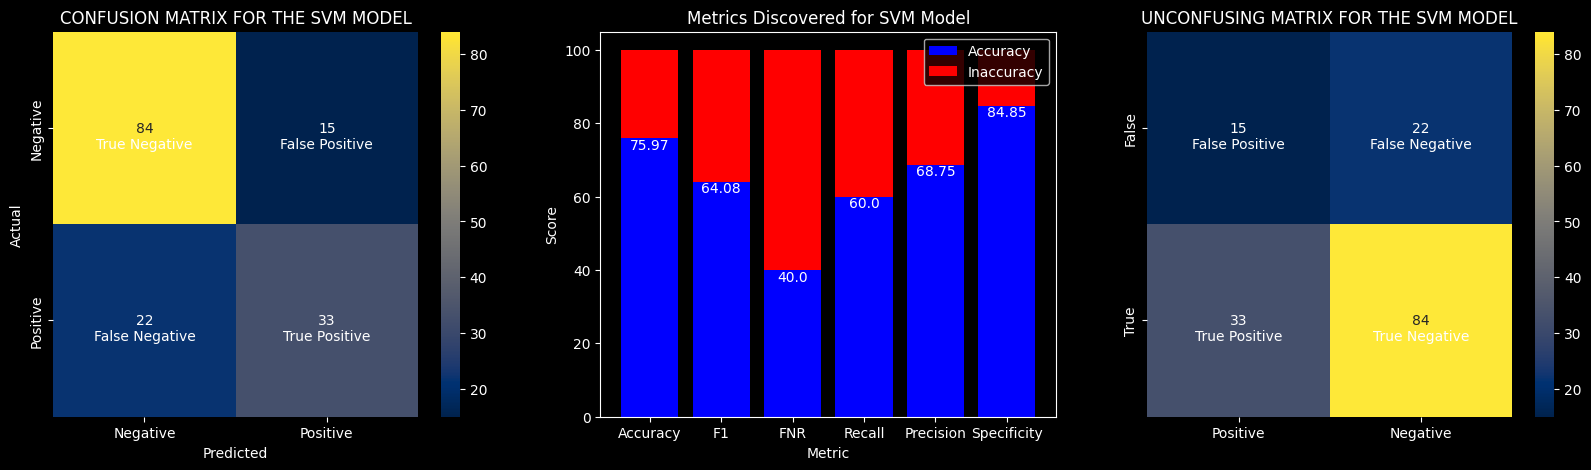

In [47]:
## Display Confusion and Unconfusing Matrix for the SVM Model
show_matrixs(new_svm, 'SVM')

### Example Output
___Generated at the same time as writeup___


<img src="Assessment_Outputs\optimised results just svm.png">

### Metric Appraisal

Examining the Confusion Matrix sheds light on the model's ability to correctly predict class instances. With 80 True Negatives and 35 True Positives, the model demonstrates clear effectiveness in identifying non-diabetic and diabetic patients, respectivly. However, the presense of 19 False Negatives and 20 False Positives indicates that improvement is definatly desireable. False Negatives, in particular, are the most concerning as missed diabetic referrals can lead to severe health consequences.

The performance of this model is highly relavent to its completion. Given the task of paitent referral, if too many True positives are missed: the system becomes untrustworthy. Conversly, if the model becomes too loose, it is quite possible for more non-diabetic patients to be referred by mistake. This can be inconsequential, if kept to a minimum, and is usually the key to generalising unseen features better. If too many are referred by mistake, this will delay referral for paitents who do actually have diabeties and would benefit from meeting a consultant.

Firstly, the accuracy normally hovers between 74% and 78%. This indicates the overall correctness of the models predictions, but doesnt give much information about how well the model has classified its objects. With this, further metrics must be analysed to truly understand the behaviour of the model. For instance, the F1 score, bringing a balance of precision and recall, stands at aproximately 64-66%. This metric helps to preform damage control on areas which recall lacks proficency, namely class imbalance within the training data. Given this metric represents the same percentage of non-diabetic patients in the initial dataset, it is not a clear enough indication about how the model has predicted diabetic patients. 

The False Negative Rate (FNR), calculated to rest between 35% and 40%, underlines this concern. A high FNR implies that there is a significant proprotion of diabetic patients who might be undiagnosed, if relying solely on the model for referrals. Consequently, this could delay the treatment for affected people: potentially resulting in a worsend case of diabeties. Alternatively, the model shows a strong specificity of apromimately 77-80%, showing its clear ability to indicate True Negatives. This is great, as it means there shouldnt be as many False Positives: keeping the referal process decongested, reducing strain on the healthcare system. 

The Recall, also known as the True Positive Rate or sensitivity, measures the model's ability to corrrectly identify positive instances from all the actual positive instances: essentially the inverse of the False Negative Rate. In this instance, the recall score is aproximately 60-65%, showing the model was correctly able to identify 2:3 of the diabetics in the dataset. While this is good, it only demonstrates moderate ability to detect diabetic patients: highlighting the risk of False Negatives (As Directly shown by the FNR). Considering the critical nature of patient referral in healthcare, a recall score of 62.5 is not ideal and leaves room for lots of improvement. By comining the two values of Recall and Precision, 62.5% and 64% respectivly, it is clear that model is predicting a respectable number of the diabetic patients.

## Ensamble Evaluation

### Ensamble Metrics

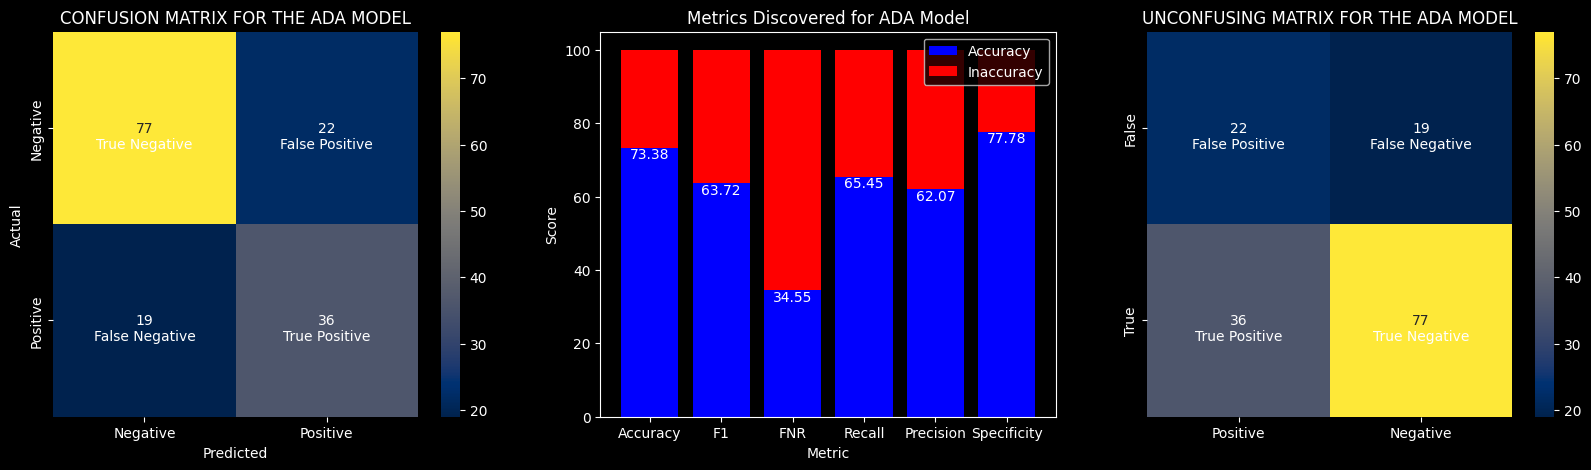

In [48]:
## Display Confusion and Unconfusing Matrix for the AdaBoost Model
show_matrixs(new_ada, 'ADA')

### Example Output
___Generated at the same time as writeup___


<img src="Assessment_Outputs\optimised results just ada.png">

### Metric Apprasial 

The accuracy of 76-80% indicates an overall great correctness of the predictions made by the model. While accuracy is an essntial metrtic for discussing succession, it has already need noted that this metric alone is unrealiable and can lead to a gross under-representation of the models overall preformance. In order to understand a more comprehensive view, other analytic methods must be employed. 

Interestingly, this ADA model predicted the same number of True Negatives as the SVM model. This is excellent, as the specificity for the SVM model was the strongest value. Ensuring this number stays high is paramount in minimising the number of false positives, helping to reduce stress on the medical staff by lowering unnecessasary referrals. This still resulted in 19 members of the test class being wrongfully reccomended for referral, so its important to note that this number could certainly still be improved. Scaling this ratio up, out of 100k non-diabetic patients: roughly 20k would be referred. This could be a potentially dangerous statistic when automatically serveying the nation. 

The precision, which indicates a low false positive rate, stands at 67%: representing a 3% increase from SVM. While this upgrade is minimal, its important to note the success of not trading specificity for precision. This represents a direct imrpovement in predictions, and the models ability to reduce strain on the healthcare sector my reffering more diabetic patients. Recall predications, standing strong at 70.9%, highlight this perfectly. Representing the models ability to correctly identify positive cases, out of all cases assumed positive: this demonstraights a clear ratio of diabetic to non-diabetic patients who will be admitted for referral. Admitedly, this result is not overly impressive: 30k out of 100k patients referred would be non-diabetic. This number is dangerously high, and thus cannot be relied apon fully. Other physical tests would still be reccomended to confirm the validity of the prediction.

Looking at the confusion matric, its possible to see that of the 154 test paitents: the model correctly identified 39 diabetic patients, 16 were missed. In addition to these correctly referred patients, 19 non-diabetic patients were also admitted. This statistic shows that of all referrals made by this model, 70% of them would be accurate. This still leaves room for improvement. Thirty percent of the time referrals made would be wasting the specialists time. Ultimately, this would lead to the mean average appointment time being reduced, also allowing doctors to preform other tasks whilst waiting for the next paitent. These extra paitents referred, whilst inconvient to the potential patients, would help to free time up for the doctors. This free time, whilst certainly not free, allows the doctor to choose where time would best be spent whilst waiting for the next appointment. Hopefully, this would also help to reduce the overall stress of the doctor.

## Possible Areas for Improvement

### Unbalanced Datasets

Unbalanced datasets, such as the one provided, present challenges for any Machine Learning model: particularly the SVM and Ensamble methods discussed. In this dataset the majority class, Non-Diabetic patients, are a domination of 2:1. This dominanace of the Diabetic class could lead to a sevear underrepresentation in the classes learned characteristics, leading to poor performance when attempting to generalise unseen membors of the minority class. Poor generalisation of this nature normally occurs because machine learning models prefer to minimise errors, usually resulting in a favor to the majority class and creating bias. 

SVMs are particularly vulnerable to marginalised data. They aim to find a hyperplace which best splits the classes with a maximal margin. If one class is significantly larger than the other, as is present here, the margin may favour the majority class, leading to poor classification of the minority class. This is problematic, the minority class is the one which needs to be identified. AdaBoost has this equal vulnerability. Considering it relies on a collection of base learners, if these learners are susseptable to bias: the overall model becomes flawed. This could be attributed to some of the shortcomings seen with with the ensambles method too. Given trees are generated from subsets of the training data: it is entirely possible for subsets to contain more non-diabetic instances. This would ultimately create a strong bias for predicting non-diabetic instances. Random Forest, the estimator chosen to work in conjunction with AdaBoost, does have method of mitigating the impact of class imbalance to some degree. One example of this, the weighted voting system used to determain a new datapoints classification. The process of aggorgating outputs to create a final decision places a higher reliability that the choice made was correct.

#### Resampling

One of the most common ways of addressing imbalanced datasets is through a process called resampling. This has two forms: Oversampling and Undersampling. Oversampling referrs to the process of adding class instances to the minority, undersampling referring the removing of majority class members. These options both come with negatives with the goal of accomplishing the same positive: negating class bias. When oversamplig, operators must be consious of methods used. Random Oversampling can easily lead to overfitting as models will quickly assume a regularity due to repeated class instances. 

A more neuanced approach might be through the use of Synthetic Minority Oversampling Technique (SMOTE). This is the process of generating new minority class instances by interpolating between existing minority class members, curbing the overfitting problem previously observed. An easy to estimate downfall of this method is the assumption of possible true instances. If interpolation does not correctly resolve a True label location in the feature space, this could negativly impact the system. This is because a model is only able to predict given its training data, if too many instances on the wrong side of the real deicison boundary are incorrectly labelled it could easily lead to errors in the crucial decision boundary.

Undersampling offers its own selection of algorithms. Similarly to Oversampling, Random Undersampling removes instances of the majority class until a balanced dataset is acheived. If a large enough dataset is provided, or a class imbalance isnt too great: this method could be perfect. It is light weight and quick, but may lead to deletion of instances which are close to the decision boundary and so result in a lowered integrity of the ending model. Better choices for undersampling might include Near Miss. This algorithm is designed to split the majority class into subsets, randomly deleting instances furthest away from the decision boundary. This helps to preserve the possible integrity lost in Random Undersampling, whilst maintaining the diversity of the majority class. 

Given the small dataset provided, Undersampling should absolutly not be considered. Deleting half of the majority class would be far too significant to the integrity of the model and its ability to predict non-diabetic patients. With that in mind, a combination of undersampling and oversampling could acheive a harmonic balance, not adding too much potential junk data and not deleting samples holding crucial data about the decision shape.

### Paramater Tuning

To say the absolute best paramaters have been found would be ignorant. There is always room for imrpovement, until there isnt. Given the task at hand, the resources and time available: apt paramaters have been found. Given more time and more invasive testing, it is likely more idealistic values could be acheived. However, the thirty-seven and a half hours spent running simulations have shown these to be the most optimal thus far. Increasing the accuracy of the steps between values used would be a good position to start. This would help to identify the exact best value, instead of an approximate "near hit". It must be considered that some incorrectly predicted values are caused by different paramater uses. 

# Model Comparison

After analyisng these models, their leaps and pitfalls, its clear they both have strong merit for their own use case. Known for thier strong binary classification ability, they have both proven ability to correctly identify diabetic patients amounts non-diabetic patients. Given their different specalties, it could be foolish to assume their same performance. Whilst metrics show results of a similar nature, the different models characteristics make it suited for vastly different scenarios. The healthcare industry is already struggling from a workload too great, this model should assist in their aid to the public. This should be the main condition that the models are checked against. Additonally, the model must be designed with the budget of the public health sector in mind. Their known low budget means it must be assumed their hardware is potentially outdated and may not able to handle intensive calculations. Not only could their hardware be outdated, if the sector were to purchase dedicated hardware to run the algorithm: the more intensive the algorithm, the more that would occur in hardware expenses.



#### _QUICK REMINDER OF THE RESULTS_
<img src="Assessment_Outputs\optimised results just svm.png" style="width:90%;">
<img src="Assessment_Outputs\optimised results just ada.png" style="width:90%;">

## Intensity

The models both pose good results, Ada taking the number one position by a 7% lead on SVM's Recall potential. This highlights a direct relavence to the model's ability in medical diagnosis, as False Negatives and False Postives both hold significance in determining the speed at which diabetic referrals will flow. Understanding the hardware constrains of each model is essential in deciding on a final reccomendation. Weather or not the 7% increase is worth extra hardware requirements must be a focus of consideration. As discussed, more intesnive calculations would cost more money in terms of power consumption and hardware capability. This hardware would also undoubtably require maintance, adding to the extra cost of the Machine Learning model. This could have an adverse effect on helping the public health sector, resulting in more money spent: not less.

Another option for hosting a more powerful model, like an Adaboosted model, would be a standalone desktop in each General Practice. This would likely require training staff in how to submit profiles for evaluation, which would require money too. This option could be cheaper in the long term. Eventually, new health staff can be trained by existing health staff. This would eliminate training costs in a long-term campaign, and allow development of new models to replace the one reccomended in this project: provided the same interface is used for model interactions. Given the relativly low computational needs of the compared models, this method of adoption is entirely reasonable as most old desktops have at least 8 Gigabytes of memory, 4.5 more than the is used at the height of this Notebooks execution. Understandably, the CPU of older machines might limit Ada's ability to train. This could stem from not supporting multi-threadding or simply not having fast enough cores, resulting in a far greater time needed to train the model. This problem would only grow when the training dataset is increased.

The time taken to train each the Ada model in comparison to the SVM model is 2 minutes to 4 minutes. This, roughly, two fold increase is insignificant on a training set of this size: a two minute wait time is little in comparison of 7,000 extra people being correctly identified. Taking the patience to wait the extra time, could prove invaluable as thousands more patients would be seen and less time would be wasted. This not only directly relates to saved lives of diabetic patients but also serves to not inconvieniece as many non-diabetic patients. This doubling in time complexity is surely rooted at the aggressive learning stratagies employed by Ada, itterating through training the `number of trees * number of learners`.

## Stability



## Classification Results